In [84]:
import scipy.io
from chromatic import *
from chromatic import plt, u, np
import pandas as pd
import numpy as np
import batman
import lightkurve as lk

from lmfit import Model, Parameters
from scipy.interpolate import interp1d
from RECTE import RECTE

%matplotlib inline

In [86]:
G_102_back_dict = scipy.io.readsav('../data/WFC3_data/G102/Backward_spectra.sav', verbose=False)
G_102_for_dict = scipy.io.readsav('../data/WFC3_data/G102/Forward_spectra.sav', verbose=False)
G_141_back_dict = scipy.io.readsav('../data/WFC3_data/G141/Backward_spectra.sav', verbose=False)
G_141_for_dict = scipy.io.readsav('../data/WFC3_data/G141/Forward_spectra.sav', verbose=False)

F21_BJD_times = pd.read_csv('../data/F21_bjdtimes.csv')['BJD'][:]
S22_BJD_times = pd.read_csv('../data/S22_bjdtimes.csv')['BJD'][:]

In [88]:
visits = {
    'F21': {
        'Grism': 'G141',
        'Forward': G_141_for_dict,
        'Backward': G_141_back_dict,
        'wave_lower': 1.13, # determined by hand
        'wave_upper': 1.66,
        'time_lower': 2459455.708,
        'time_upper': 2459455.737,
        'T0 (BJD_TDB)': 2459455.98,
        'exp (s)': 4.970405,
        'time cutoff': 2459455.77, # for removing the first orbit
        'duration': 3.5 * u.hour,
        'period': 8.463 * u.day
            },
    'S22': {
        'Grism': 'G102',
        'Forward': G_102_for_dict,
        'Backward': G_102_back_dict,
        'wave_lower': 0.80,
        'wave_upper': 1.13,
        'time_lower': 2459684.215,
        'time_upper': 2459684.242,
        'T0 (BJD_TDB)': 2459684.48, # This is 27 planetary orbits after the first transit
        'exp (s)': 9.662994, 
        'time cutoff': 2459684.27, # for removing the first orbit
        'duration': 3.5 * u.hour,
        'period': 8.463 * u.day
    }
}

In [124]:
def light_curve_model(tExp, t_mid, rp_rstar, a_rstar, u1, u2, c1, c2, c3):
    
    params = batman.TransitParams()
    params.t0 = t_mid                      #time of inferior conjunction
    params.per = 8.463 * 24*60*60                      #orbital period
    params.rp = rp_rstar                      #planet radius (in units of stellar radii)
    params.a = a_rstar                       #semi-major axis (in units of stellar radii)
    params.inc = 89.5                     #orbital inclination (in degrees)
    params.ecc = 0.0                      #eccentricity
    params.w = 88.4                       #longitude of periastron (in degrees)
    params.u = [u1, u2]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    
    m = batman.TransitModel(params, tExp)    #initializes model
    flux = m.light_curve(params)       #calculates light curve
    baseline = (c1 * tExp**2) + (c2 * tExp) + c3
    
    return flux

In [ ]:
def removeRamp(p0,
               time,
               LCArray,
               ErrArray,
               orbits,
               orbits_transit,
               expTime,
               scanDirect):
    """
    remove Ramp systemetics with RECTE

    :param p0: initial parameters
    :param time: time stamp of each exposure
    :param LCArray: numpy array that stores all light curves
    :param ErrArray: light curve uncertainties
    :param orbits: orbit number for each exposure
    :param orbits_transit: orbit number that transits occur. These orbits
    are excluded in the fit
    :param expTime: exposure time
    :param scanDirect: scanning direction for each exposure. 0 for forward,
    1 for backward
    """
    nLC = LCArray.shape[0]  # number of light curves
    correctedArray = LCArray.copy()
    correctedErrArray = ErrArray.copy()
    modelArray = LCArray.copy()
    crateArray = LCArray.copy()
    slopeArray = LCArray.copy()
    p = p0.copy()
    for i in range(nLC):
        correctTerm, crate, bestfit, slope = RECTECorrector2(
            time,
            orbits,
            orbits_transit,
            LCArray[i, :],
            p,
            expTime,
            scanDirect)
        # corrected light curve/error are normalized to the baseline
        correctedArray[i, :] = LCArray[i, :] / correctTerm / (crate)
        correctedErrArray[i, :] = ErrArray[i, :] / correctTerm / (crate)
        modelArray[i, :] = bestfit
        crateArray[i, :] = crate
        slopeArray[i, :] = slope
    return correctedArray, correctedErrArray, modelArray, crateArray, slopeArray


In [126]:
def rampProfile(crate, slope, dTrap_s, dTrap_f, trap_pop_s,
                trap_pop_f, t_mid, rp_rstar, a_rstar, u1, u2, c1,c2,c3,tExp, expTime):
    
    """Ramp profile for single directional scan

    And RECTE model parameters: number of traps, trapping coeeficient
    and trap life time

    :param crate: average count rate in electron/second
    :param slope: visit-long slope
    :param dTrap_s: extra trapped slow charges between orbits
    :param dTrap_f: extra trapped fast charges between orbits
    :param trap_pop_s: initially trapped slow charges
    :param trap_pop_f: initially trapped fast charges
    :param tExp: beginning of each exposure
    :param expTime: exposure time
    :returns: observed counts
    :rtype: numpy.array

    """


    tExp = (tExp - tExp[0])
    cRates = crate * (1 + tExp * slope / 1e7) / expTime
    
    obsCounts = RECTE(
        cRates,
        tExp,
        expTime,
        trap_pop_s,
        trap_pop_f,
        dTrap_s=[dTrap_s],
        dTrap_f=[dTrap_f],
        dt0=[0],
        lost=0,
        mode='scanning')
    
    return obsCounts

In [128]:
def RECTECorrector1(t, orbits, orbits_transit, counts, p, expTime,
                    include_transit=False):
    """correct the ackbar model for one directional scan observations

    :param t: time stamps of the exposures
    :param orbits: orbit number of the exposures
    :param orbits_transit: orbits in which transits/eclipses occur
    :param counts: observed counts
    :param p: Parameters objects to fit
    :param expTime: exposure time
    :returns: RECTE profile for correciting the light curve, best fit
    count rate array, ackbar output, slope
    :rtype: tuple of four numpy array

    """

    p = p.copy()
    p.add('crate', value=counts.mean(), vary=True)
    p.add('slope', value=0, min=-3, max=3, vary=True)
    
    rampModel = Model(rampProfile, independent_vars=['tExp', 'expTime'])
    t0 = t - t[0]  # make the first element in time array 0
    weights = np.ones_like(t0)
    # weights[np.in1d(orbits, orbits_transit)] = 0
    # weights[orbits == 3] = 0
    fitResult = rampModel.fit(
        counts,
        tExp=t0,
        expTime=expTime,
        params=p,
        weights=weights,
        method='least squares')
    fitResult = rampModel.fit(
        counts,
        tExp=t0,
        expTime=expTime,
        params=fitResult.params,
        weights=weights,
        method='powell')
    print(fitResult.best_values)
    RECTE_in = fitResult.params['crate'].value * (
        1 + t0 * fitResult.params['slope'] / 1e7)
    RECTE_out = fitResult.best_fit
    correctTerm = RECTE_out / RECTE_in
    return correctTerm, fitResult.params['crate'].value *\
        (1 + t0*fitResult.params['slope']/1e7), RECTE_out, \
        (1 + t0*fitResult.params['slope']/1e7)

In [130]:
def removeRamp(p0,
               time,
               LCArray,
               ErrArray,
               orbits,
               orbits_transit,
               expTime,
               scanDirect):
    """
    remove Ramp systemetics with RECTE
    
    :param p0: initial parameters
    :param time: time stamp of each exposure
    :param LCArray: numpy array that stores all light curves
    :param ErrArray: light curve uncertainties
    :param orbits: orbit number for each exposure
    :param orbits_transit: orbit number that transits occur. These orbits 
    are excluded in the fit
    :param expTime: exposure time
    :param scanDirect: scanning direction for each exposure. 0 for forward, 
    1 for backward
    """
    nLC = LCArray.shape[0]  # number of light curves
    correctedArray = LCArray.copy()
    correctedErrArray = ErrArray.copy()
    modelArray = LCArray.copy()
    crateArray = LCArray.copy()
    slopeArray = LCArray.copy()
    p = p0.copy()
    for i in range(nLC):
        correctTerm, crate, bestfit, slope = RECTECorrector1(
            time, 
            orbits, 
            orbits_transit, 
            LCArray[i, :], 
            p, 
            expTime, 
            scanDirect)
        # corrected light curve/error are normalized to the baseline
        correctedArray[i, :] = LCArray[i, :] / correctTerm / (crate)
        correctedErrArray[i, :] = ErrArray[i, :] / correctTerm / (crate)
        modelArray[i, :] = bestfit
        crateArray[i, :] = crate
        slopeArray[i, :] = slope
    return correctedArray, correctedErrArray, modelArray, crateArray, slopeArray

F21 Forward



🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/142 [00:00<?, ?it/s]

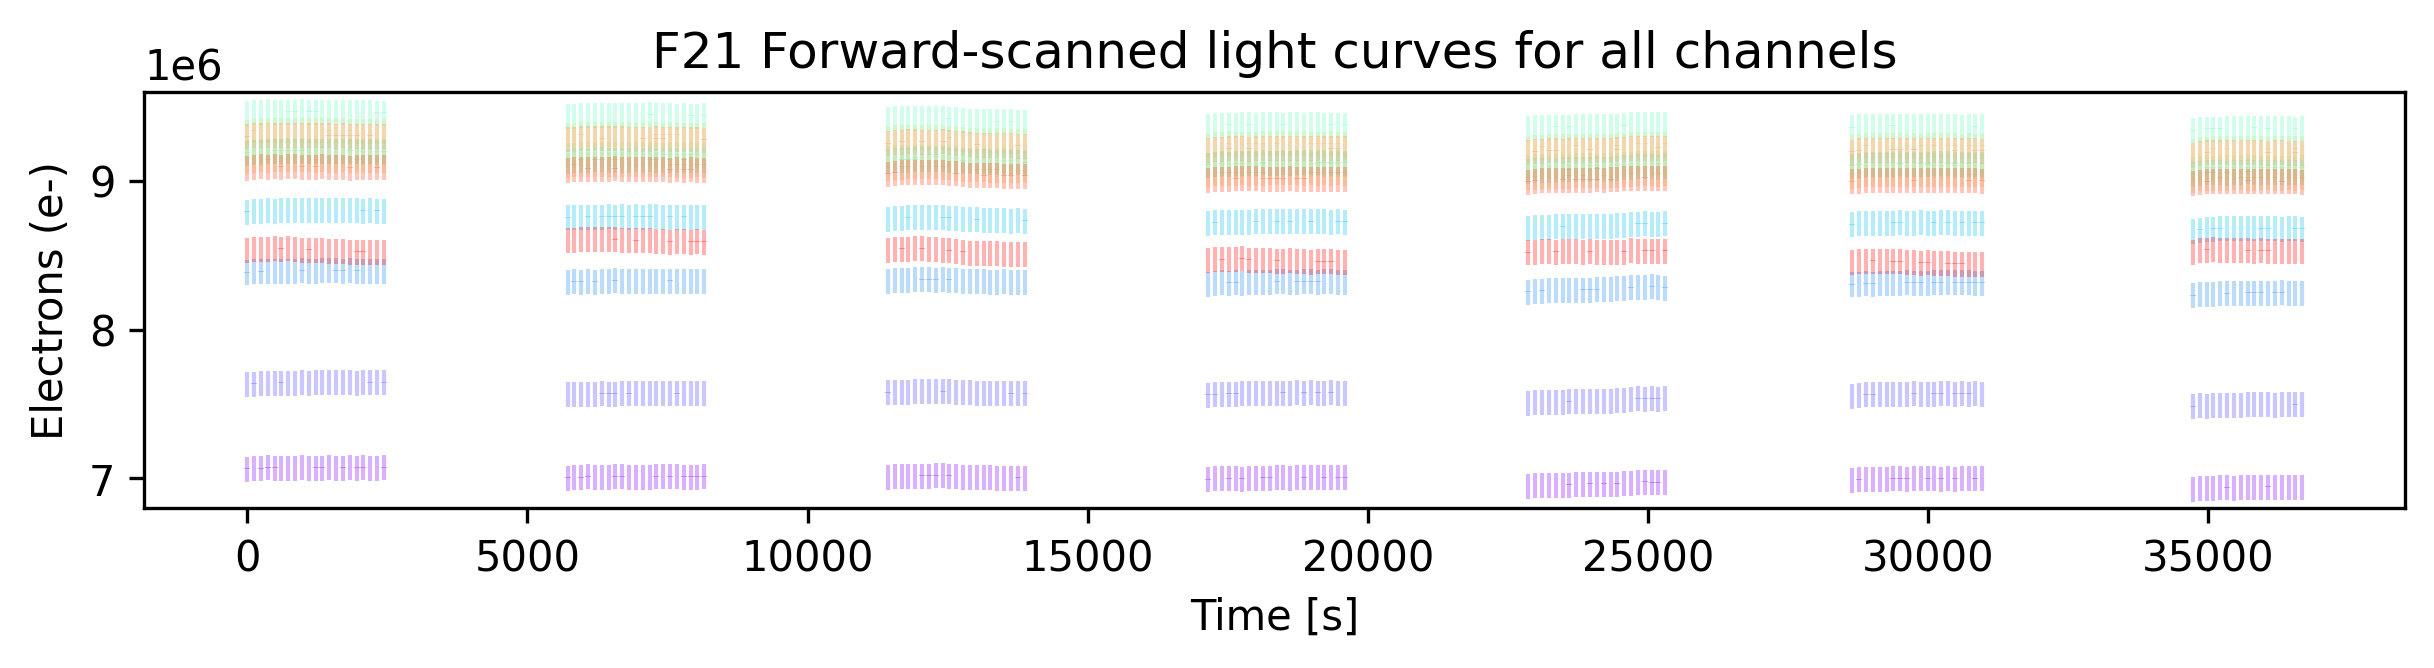

{'trap_pop_s': 199.9999999997248, 'trap_pop_f': 99.99999999940464, 'dTrap_f': 0.0, 'dTrap_s': 9.936995670756232e-09, 't_mid': 36166.55372629406, 'rp_rstar': 0.04918510304463566, 'a_rstar': 21.30445035600585, 'u1': 0.999999999999998, 'u2': 0.5, 'c1': -0.21567624528842966, 'c2': -930.6495943470176, 'c3': 87322216.97851428, 'crate': 7043929.089152068, 'slope': -2.9999999999999556}
{'trap_pop_s': 199.99999999998707, 'trap_pop_f': 99.99999999999959, 'dTrap_f': 0.0, 'dTrap_s': 2.0750068330244176e-11, 't_mid': 36280.52939594931, 'rp_rstar': 0.052598476314428454, 'a_rstar': 20.90888567272598, 'u1': 0.9999999999999994, 'u2': 0.5, 'c1': -2.5519868678043975, 'c2': -1252.4520884590959, 'c3': 258765312.94167632, 'crate': 7611758.544342408, 'slope': -2.999999999999936}
{'trap_pop_s': 199.9999999999505, 'trap_pop_f': 99.99999999995708, 'dTrap_f': 3.3306690738754696e-14, 'dTrap_s': 1.049160758270773e-12, 't_mid': 7371.019232713314, 'rp_rstar': 0.038340667366945184, 'a_rstar': 21.999999999999886, 'u1':

<Figure size 1920x1440 with 0 Axes>

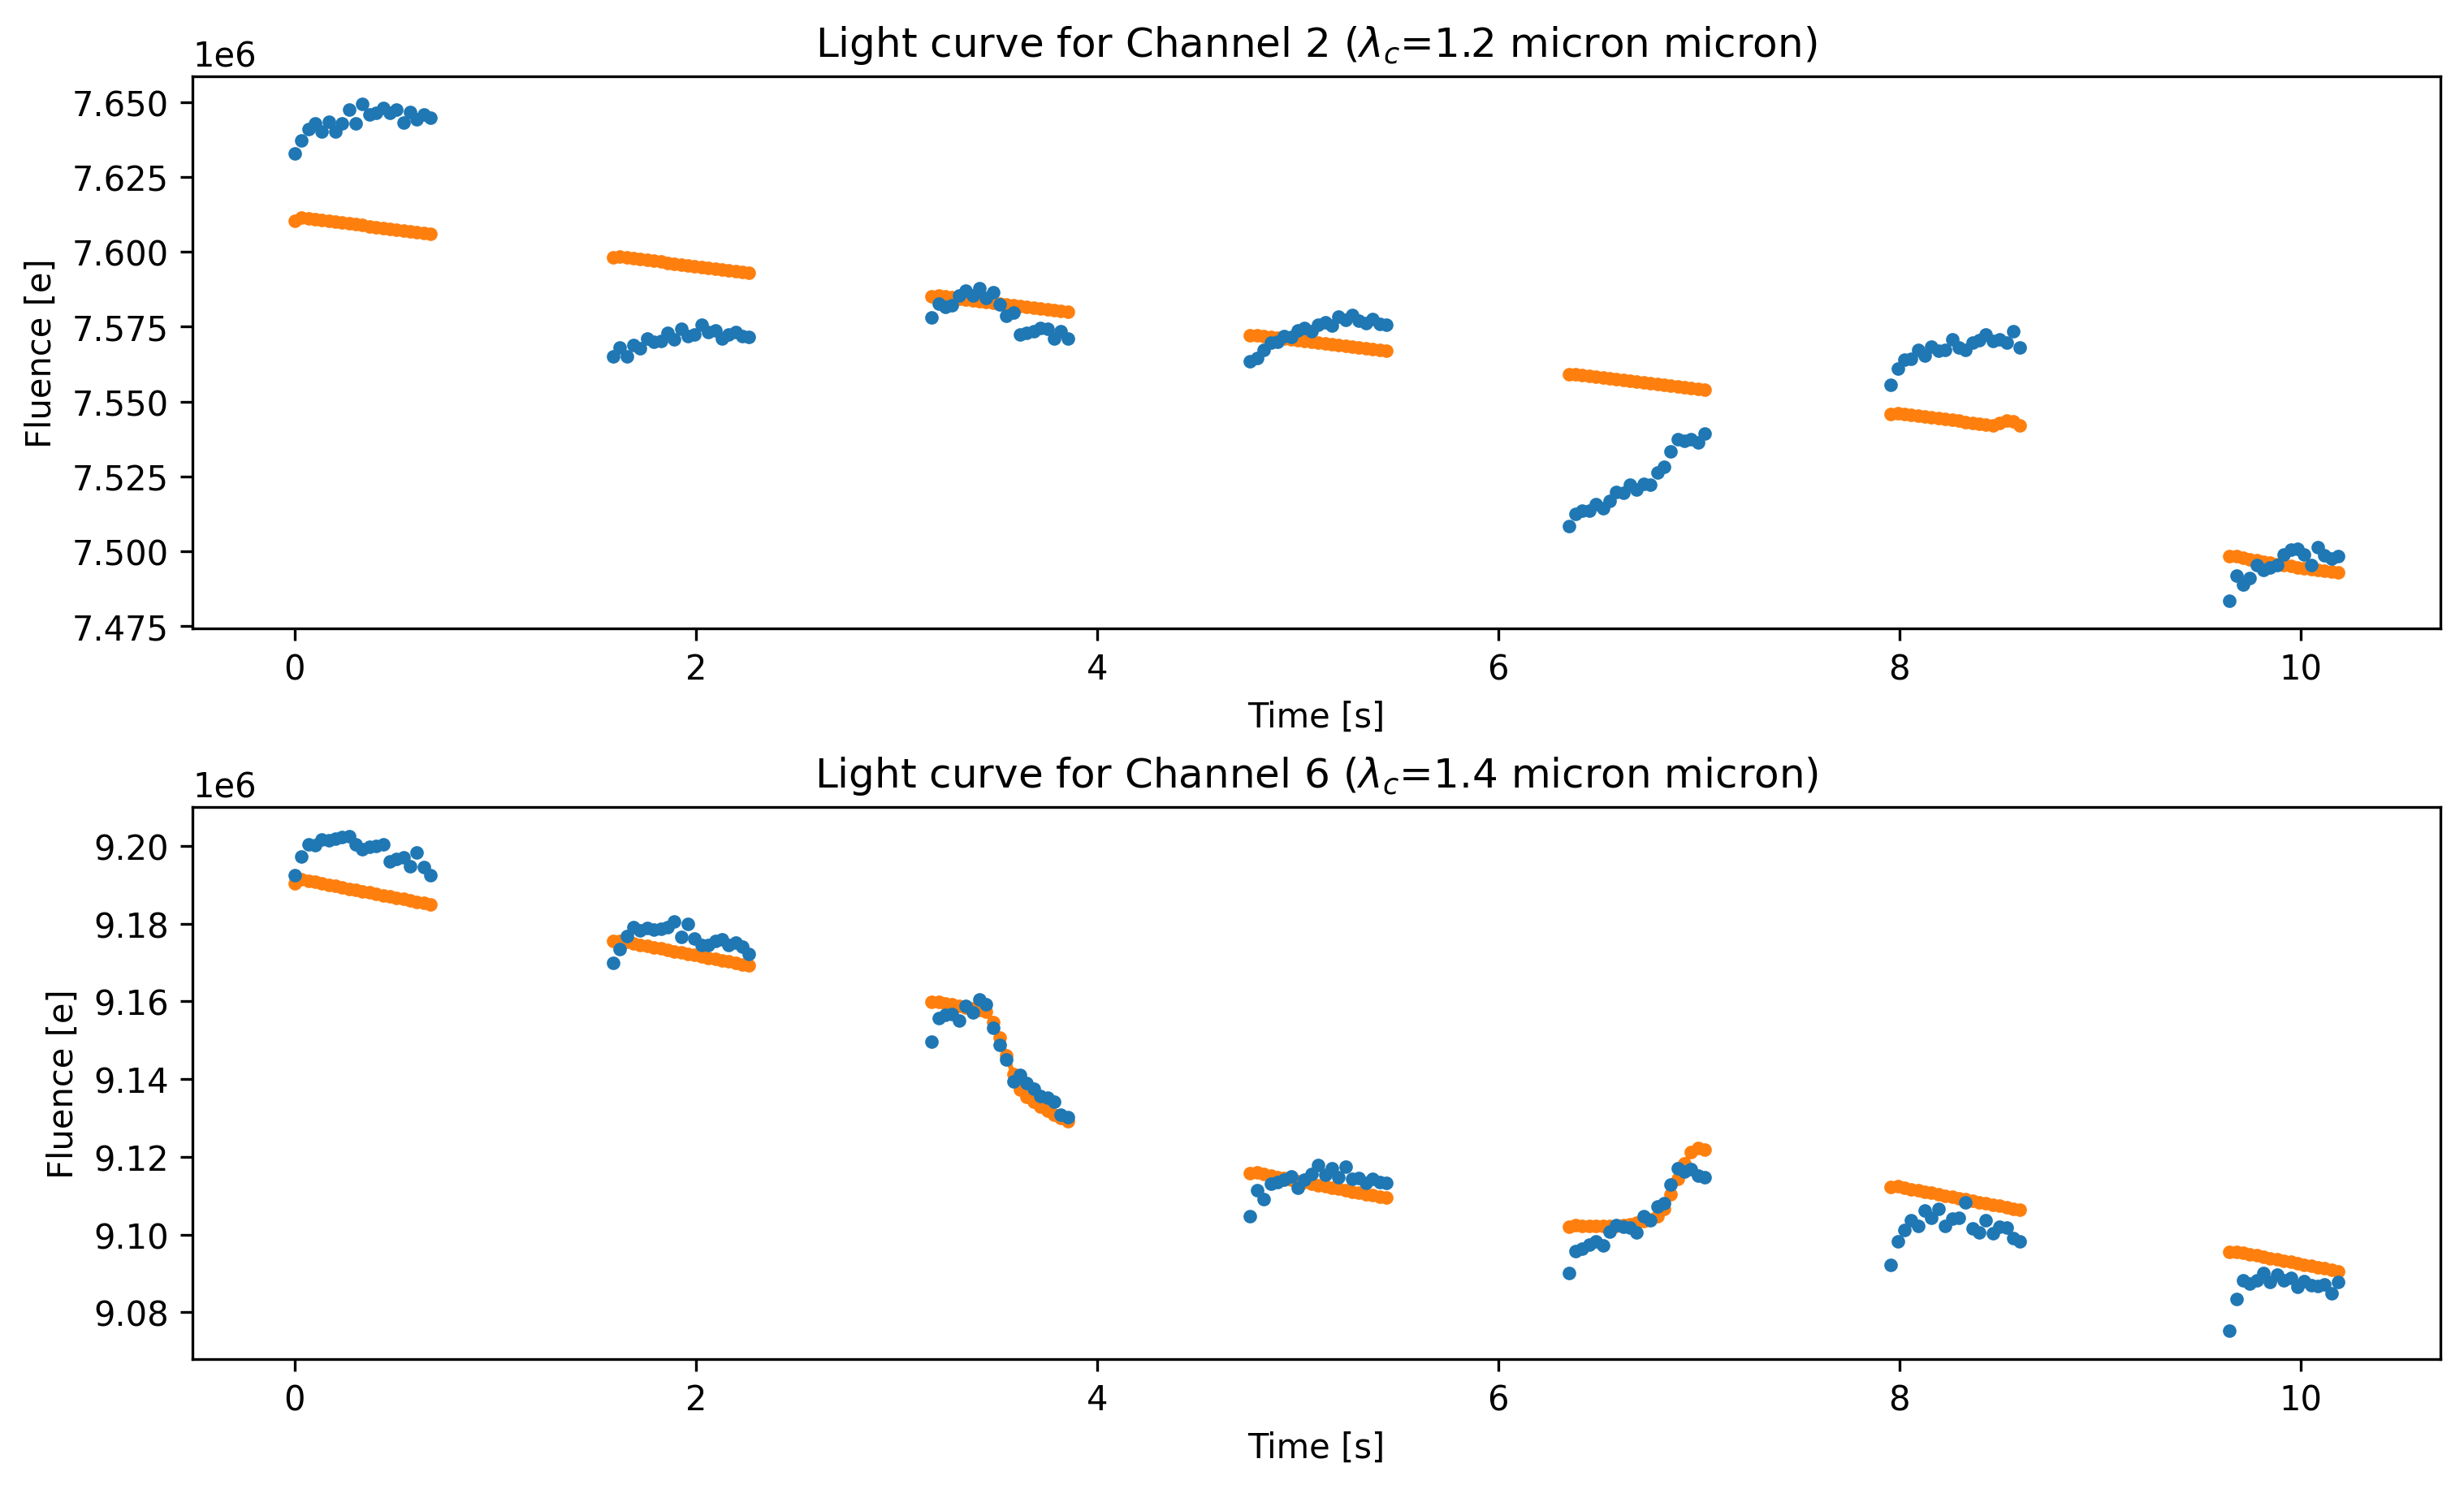

<Figure size 1920x1440 with 0 Axes>

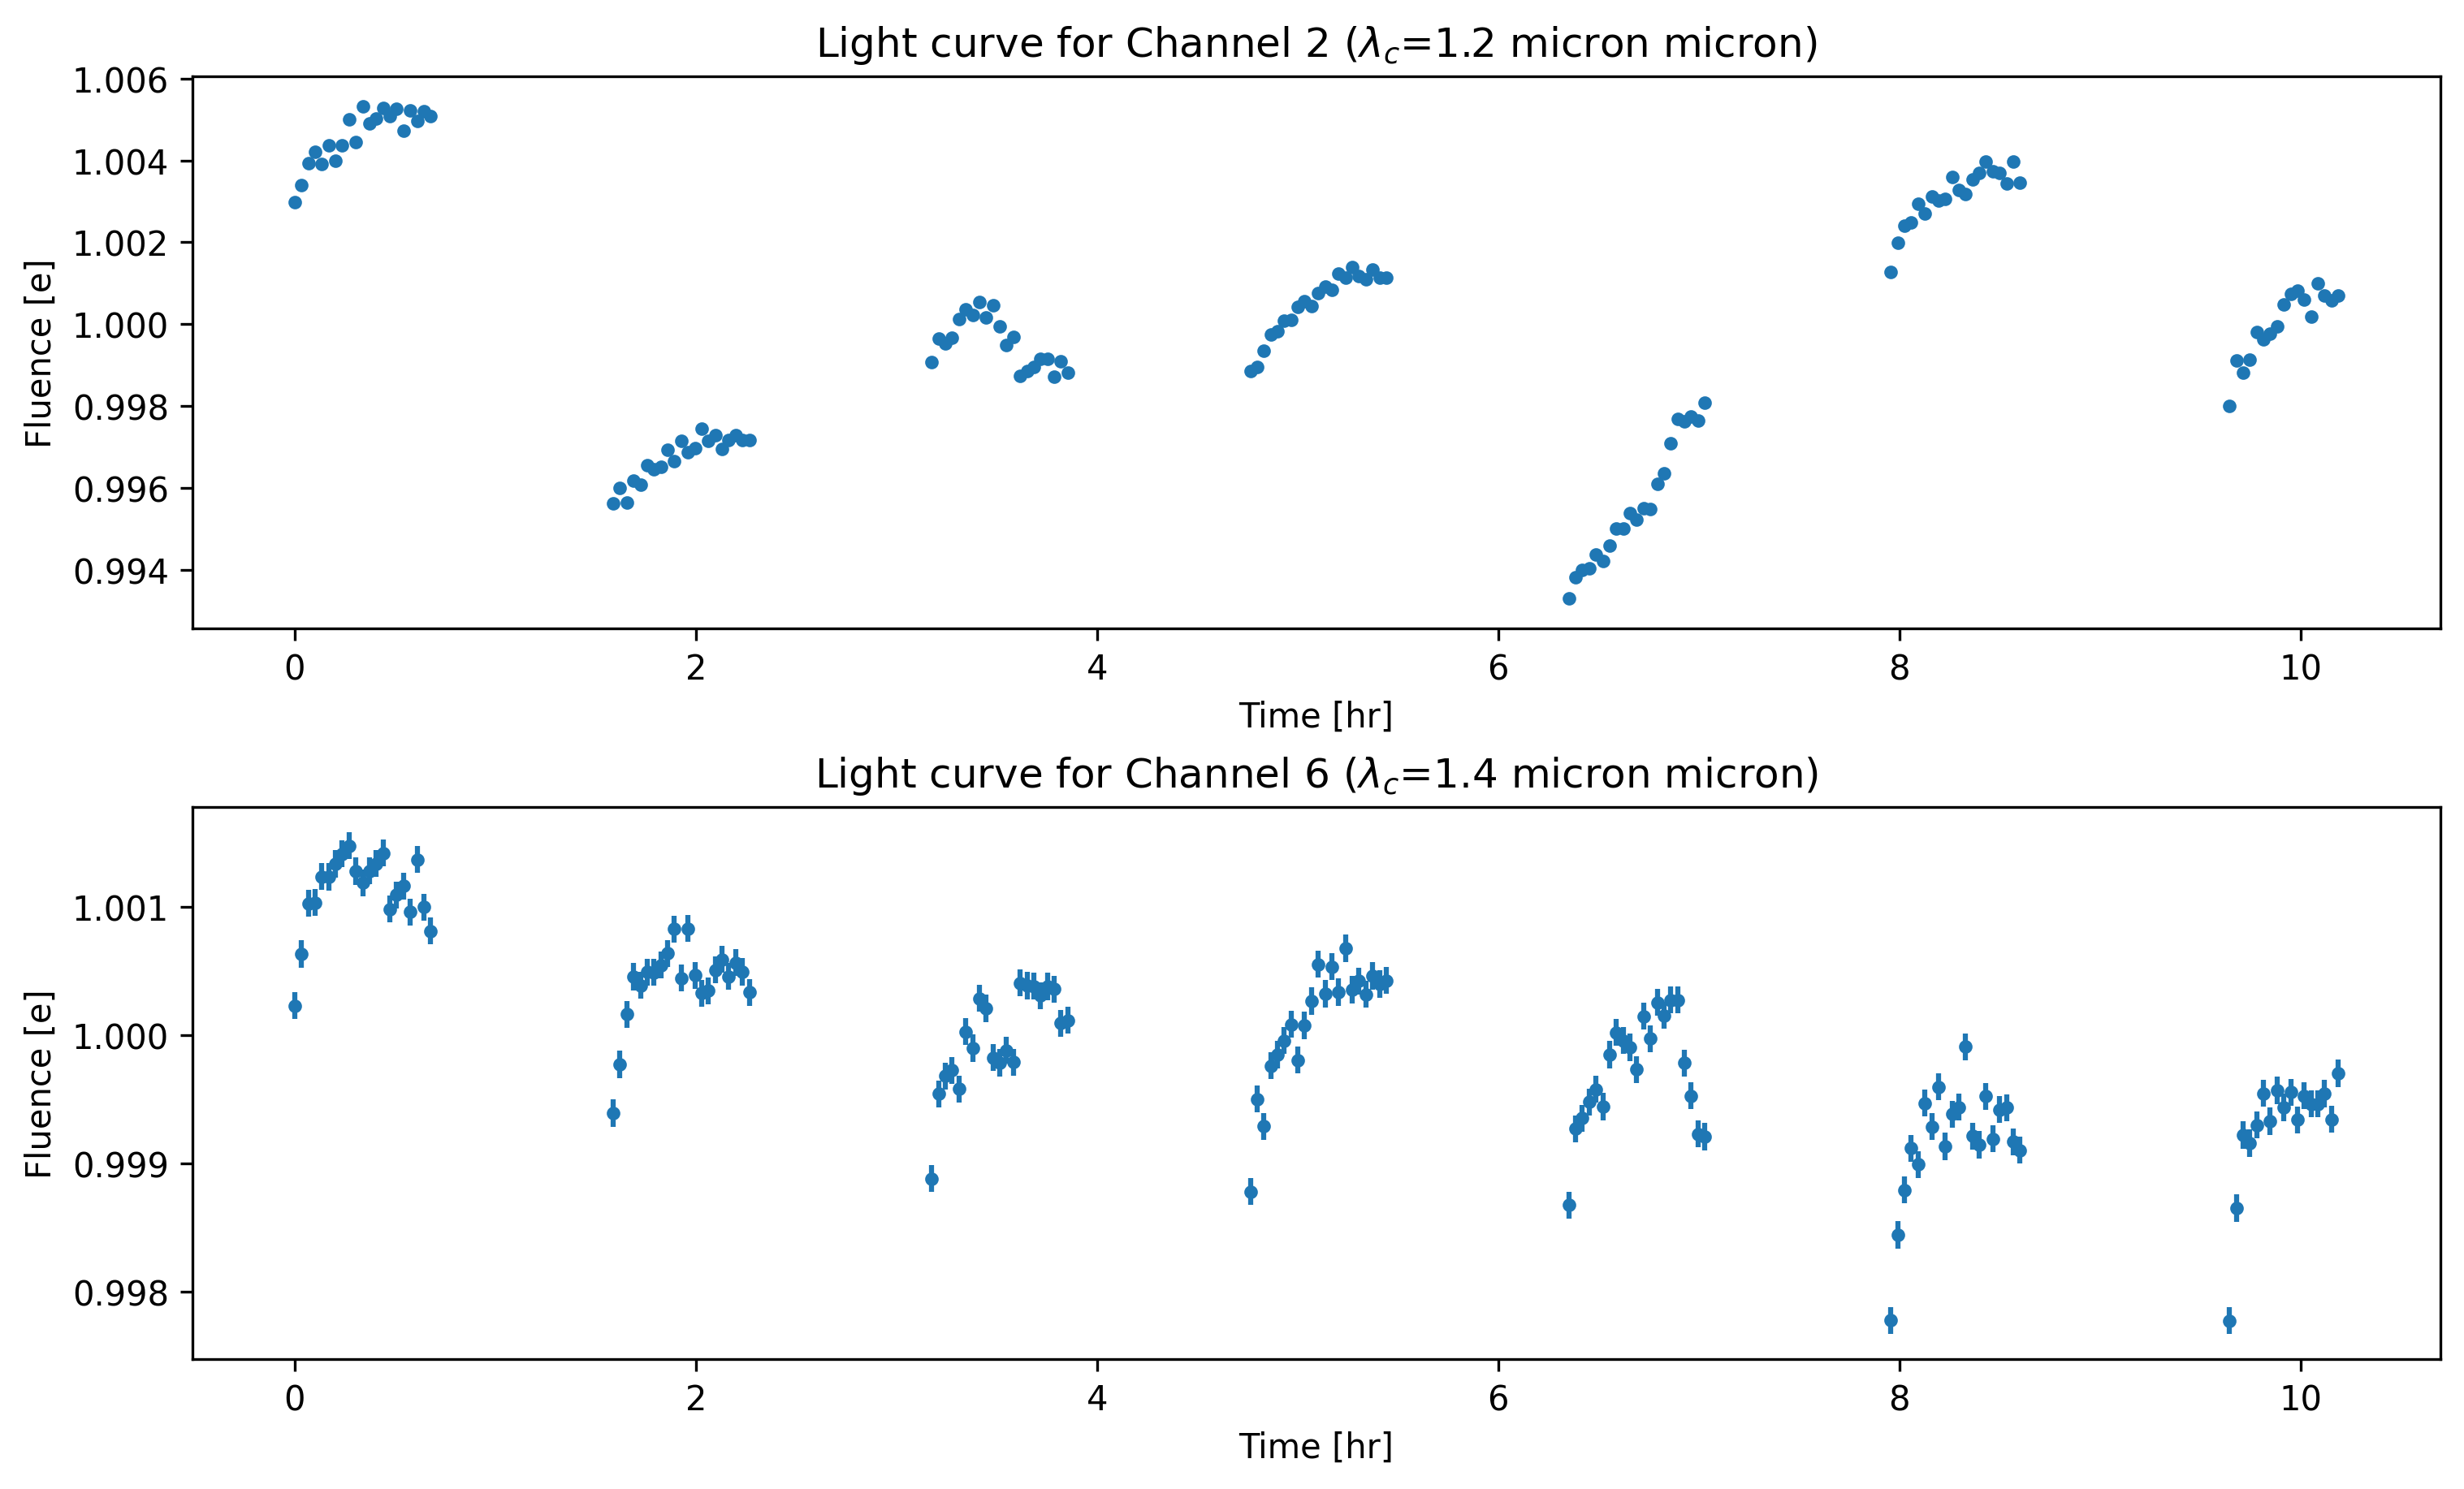

F21 Backward



🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/142 [00:00<?, ?it/s]

<Figure size 1920x1440 with 0 Axes>

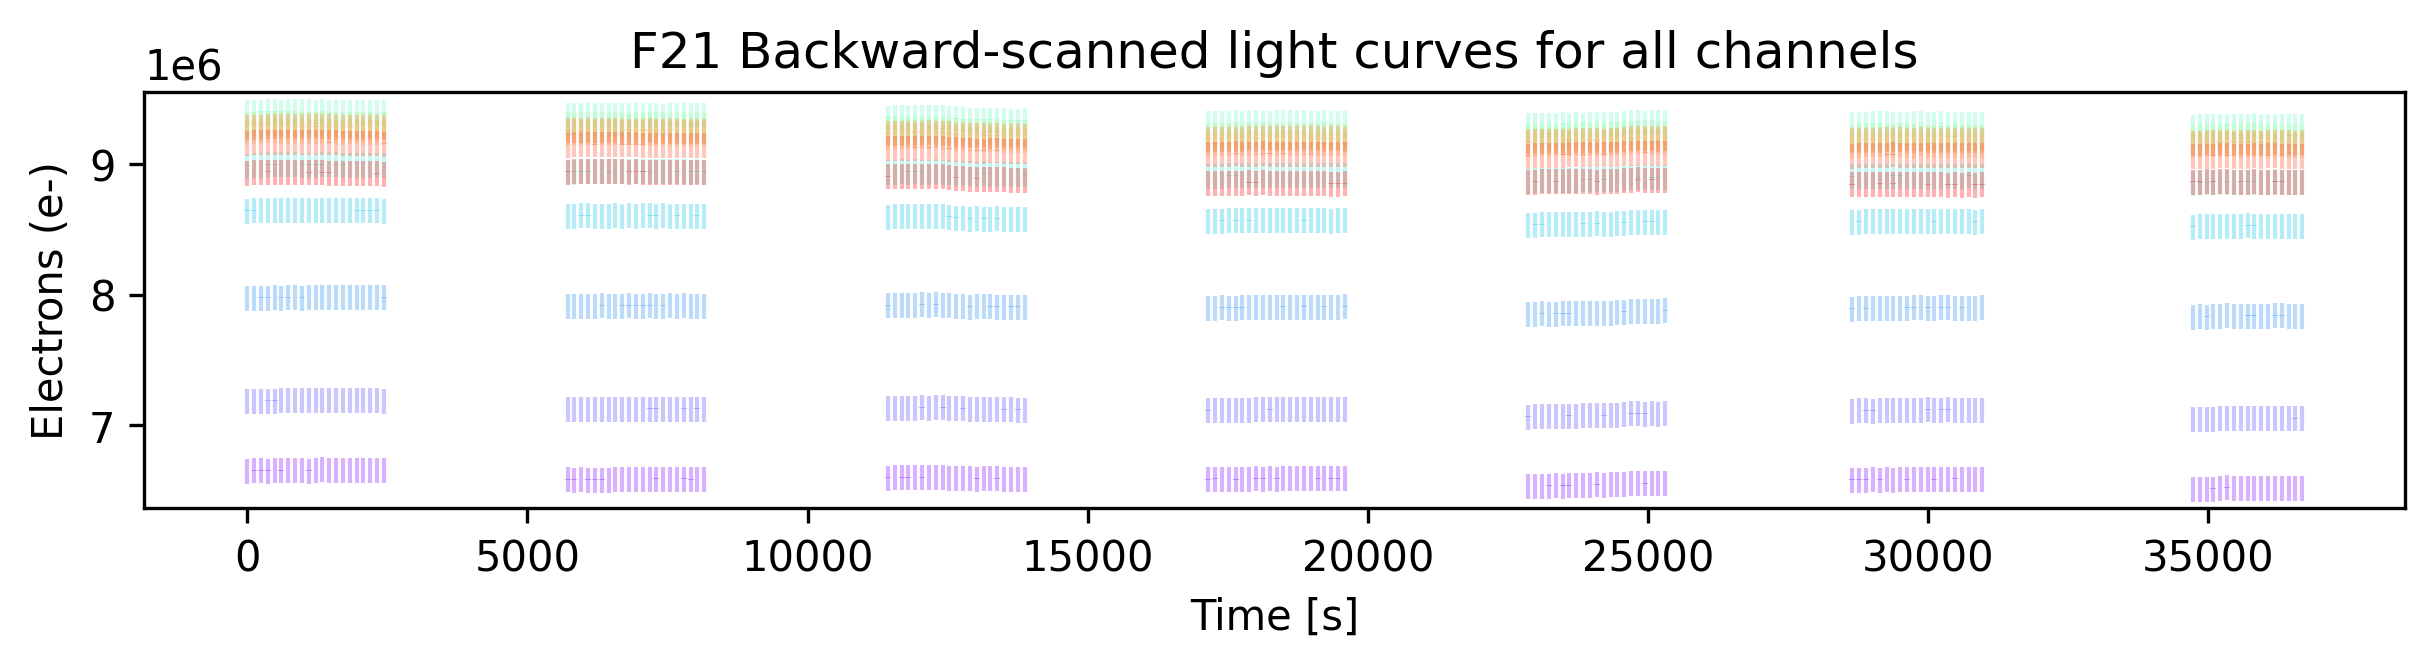

{'trap_pop_s': 199.9999999997878, 'trap_pop_f': 99.99999999987992, 'dTrap_f': 5.291322935363496e-10, 'dTrap_s': 6.480155301247237e-09, 't_mid': 36095.67426791602, 'rp_rstar': 0.05712427782072326, 'a_rstar': 21.666088227228208, 'u1': 1.0, 'u2': 0.5, 'c1': 1.7855021696228177, 'c2': -854.6587665453349, 'c3': 68841355.7943927, 'crate': 6627342.816951497, 'slope': -2.999999999999999}
{'trap_pop_s': 199.99999999990848, 'trap_pop_f': 99.99999999999974, 'dTrap_f': 0.0, 'dTrap_s': 2.6162405575291814e-11, 't_mid': 19299.37892267914, 'rp_rstar': 0.04813060584809341, 'a_rstar': 18.92135873991171, 'u1': 0.01, 'u2': -0.4999999999999965, 'c1': -37.83628619680579, 'c2': -10288.53408573227, 'c3': 516043914.7216617, 'crate': 7163535.66697304, 'slope': -3.0}
{'trap_pop_s': 200.0, 'trap_pop_f': 99.99999999965488, 'dTrap_f': 5.7276405840411826e-11, 'dTrap_s': 7.090994458280875e-11, 't_mid': 29057.158316517016, 'rp_rstar': 6.554756737386924e-13, 'a_rstar': 21.91425280537056, 'u1': 0.010000000012069006, 'u2'

<Figure size 1920x1440 with 0 Axes>

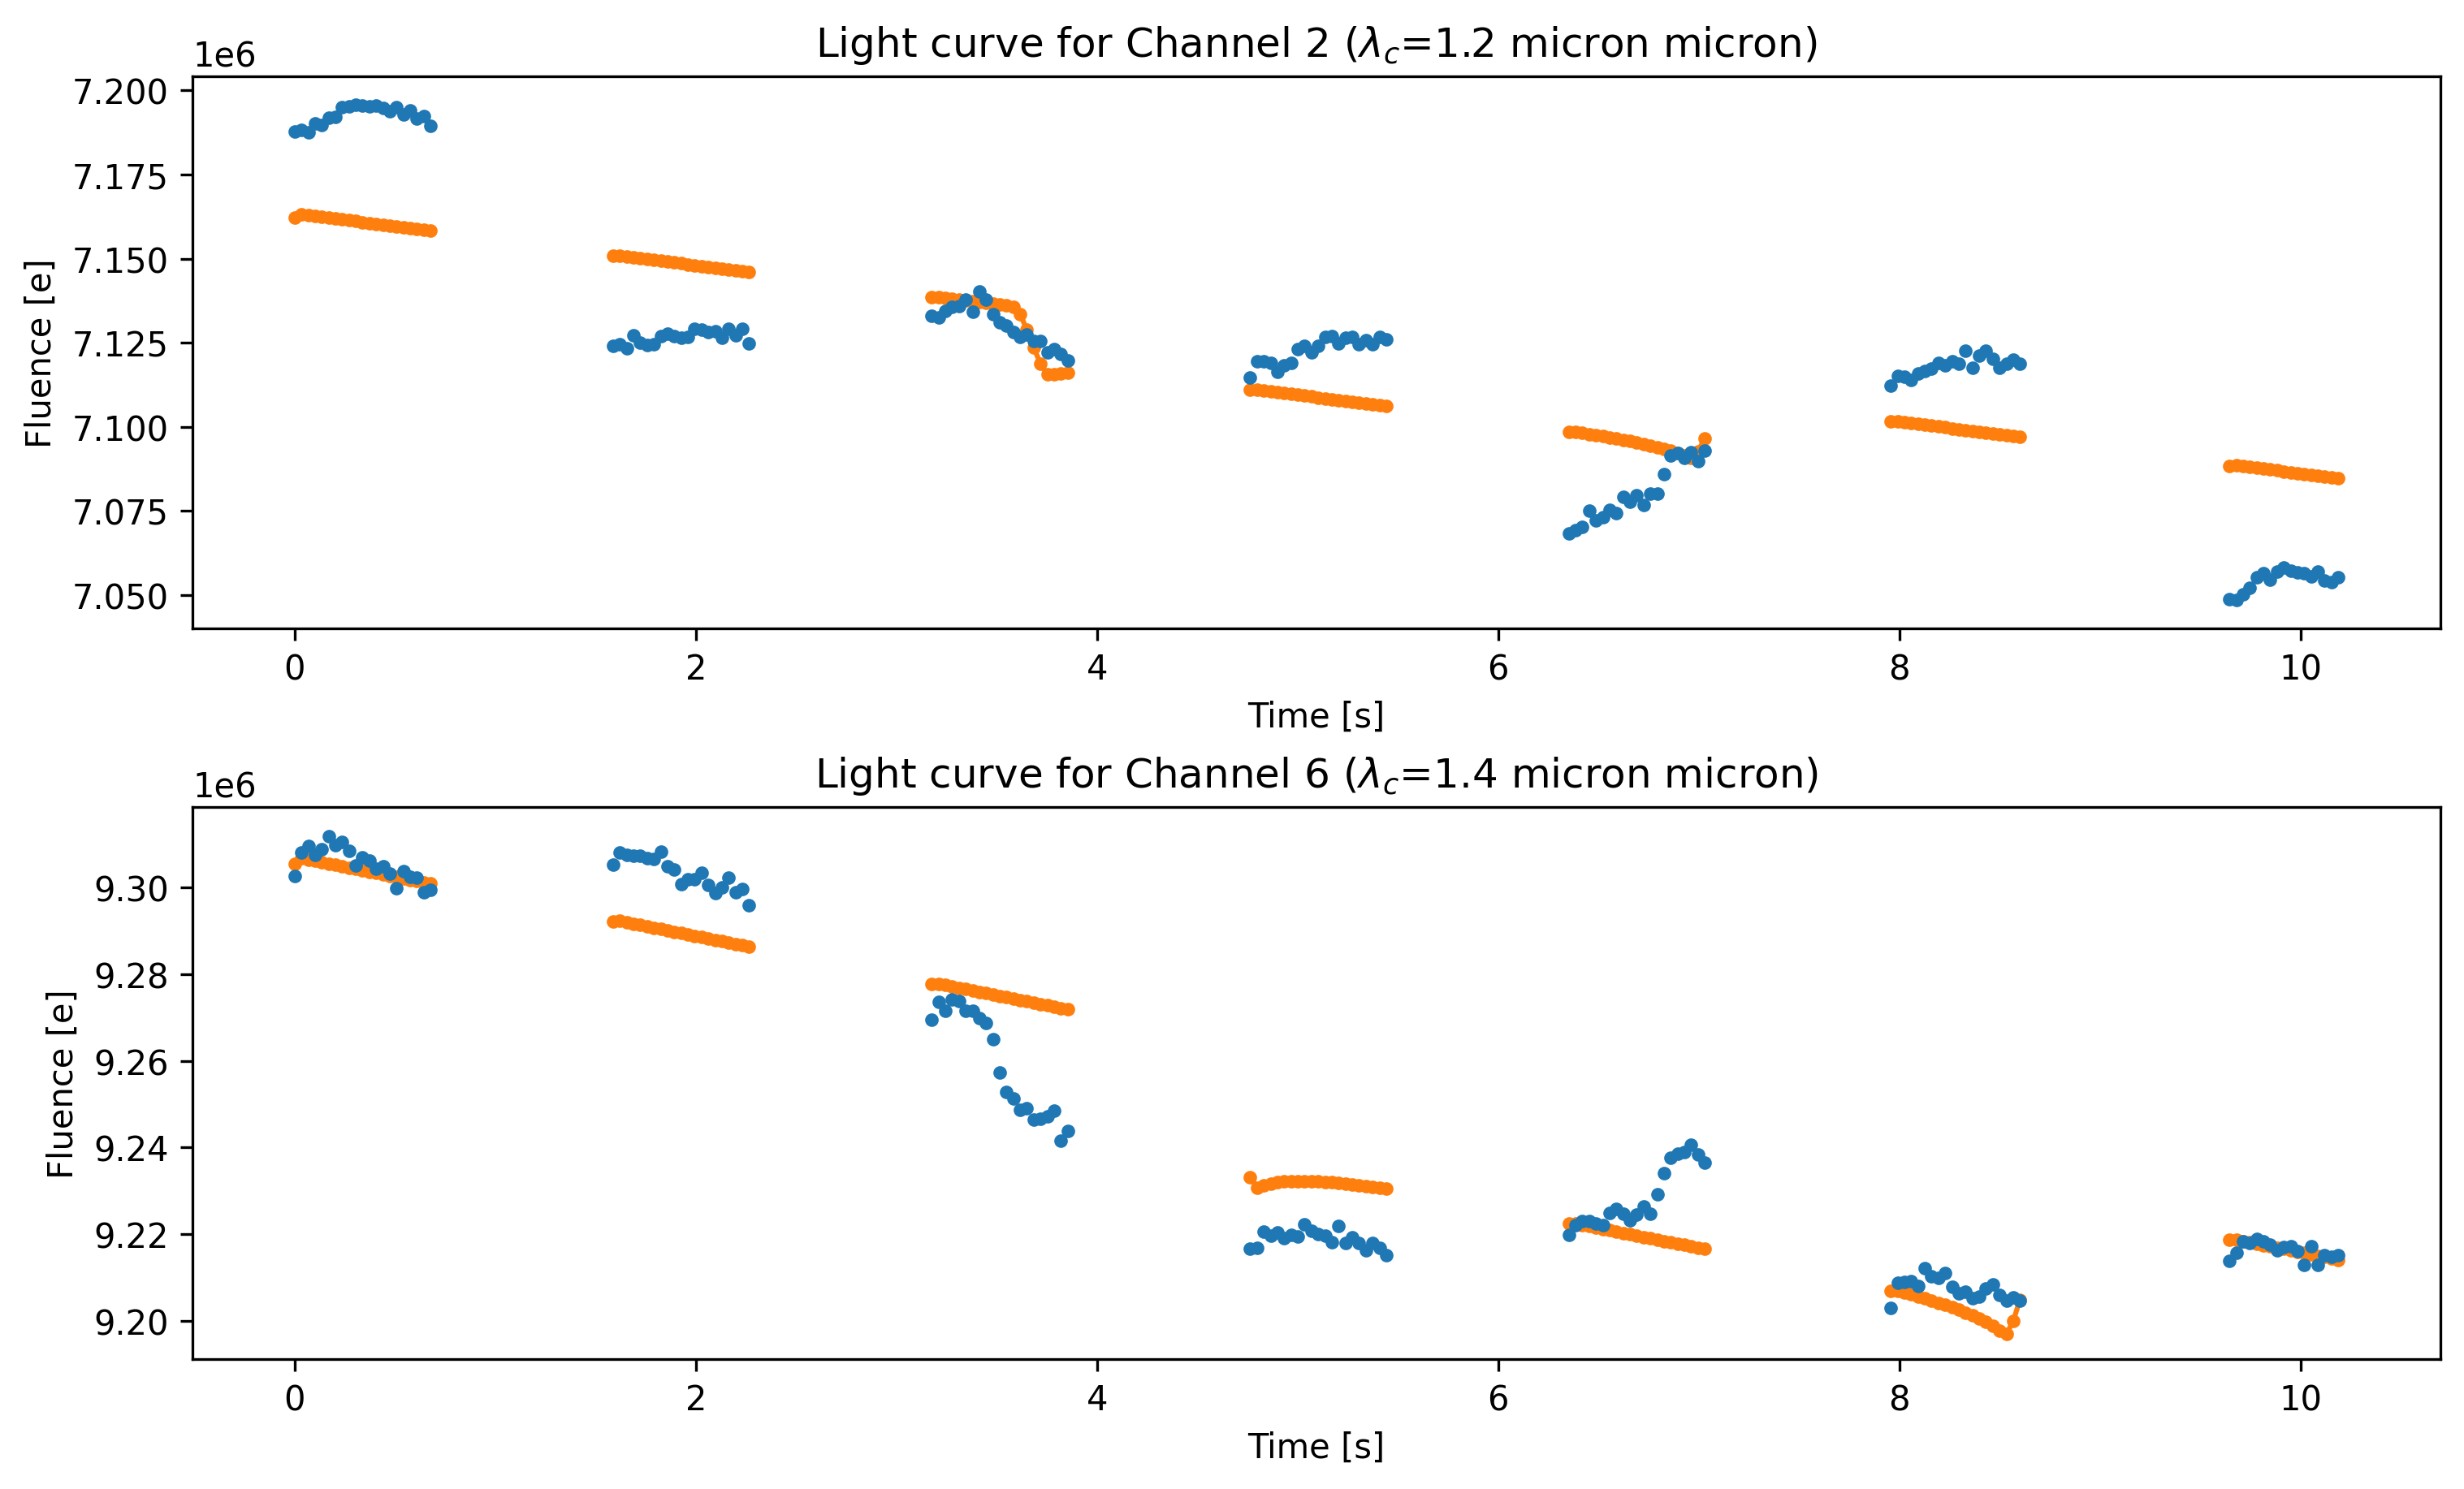

<Figure size 1920x1440 with 0 Axes>

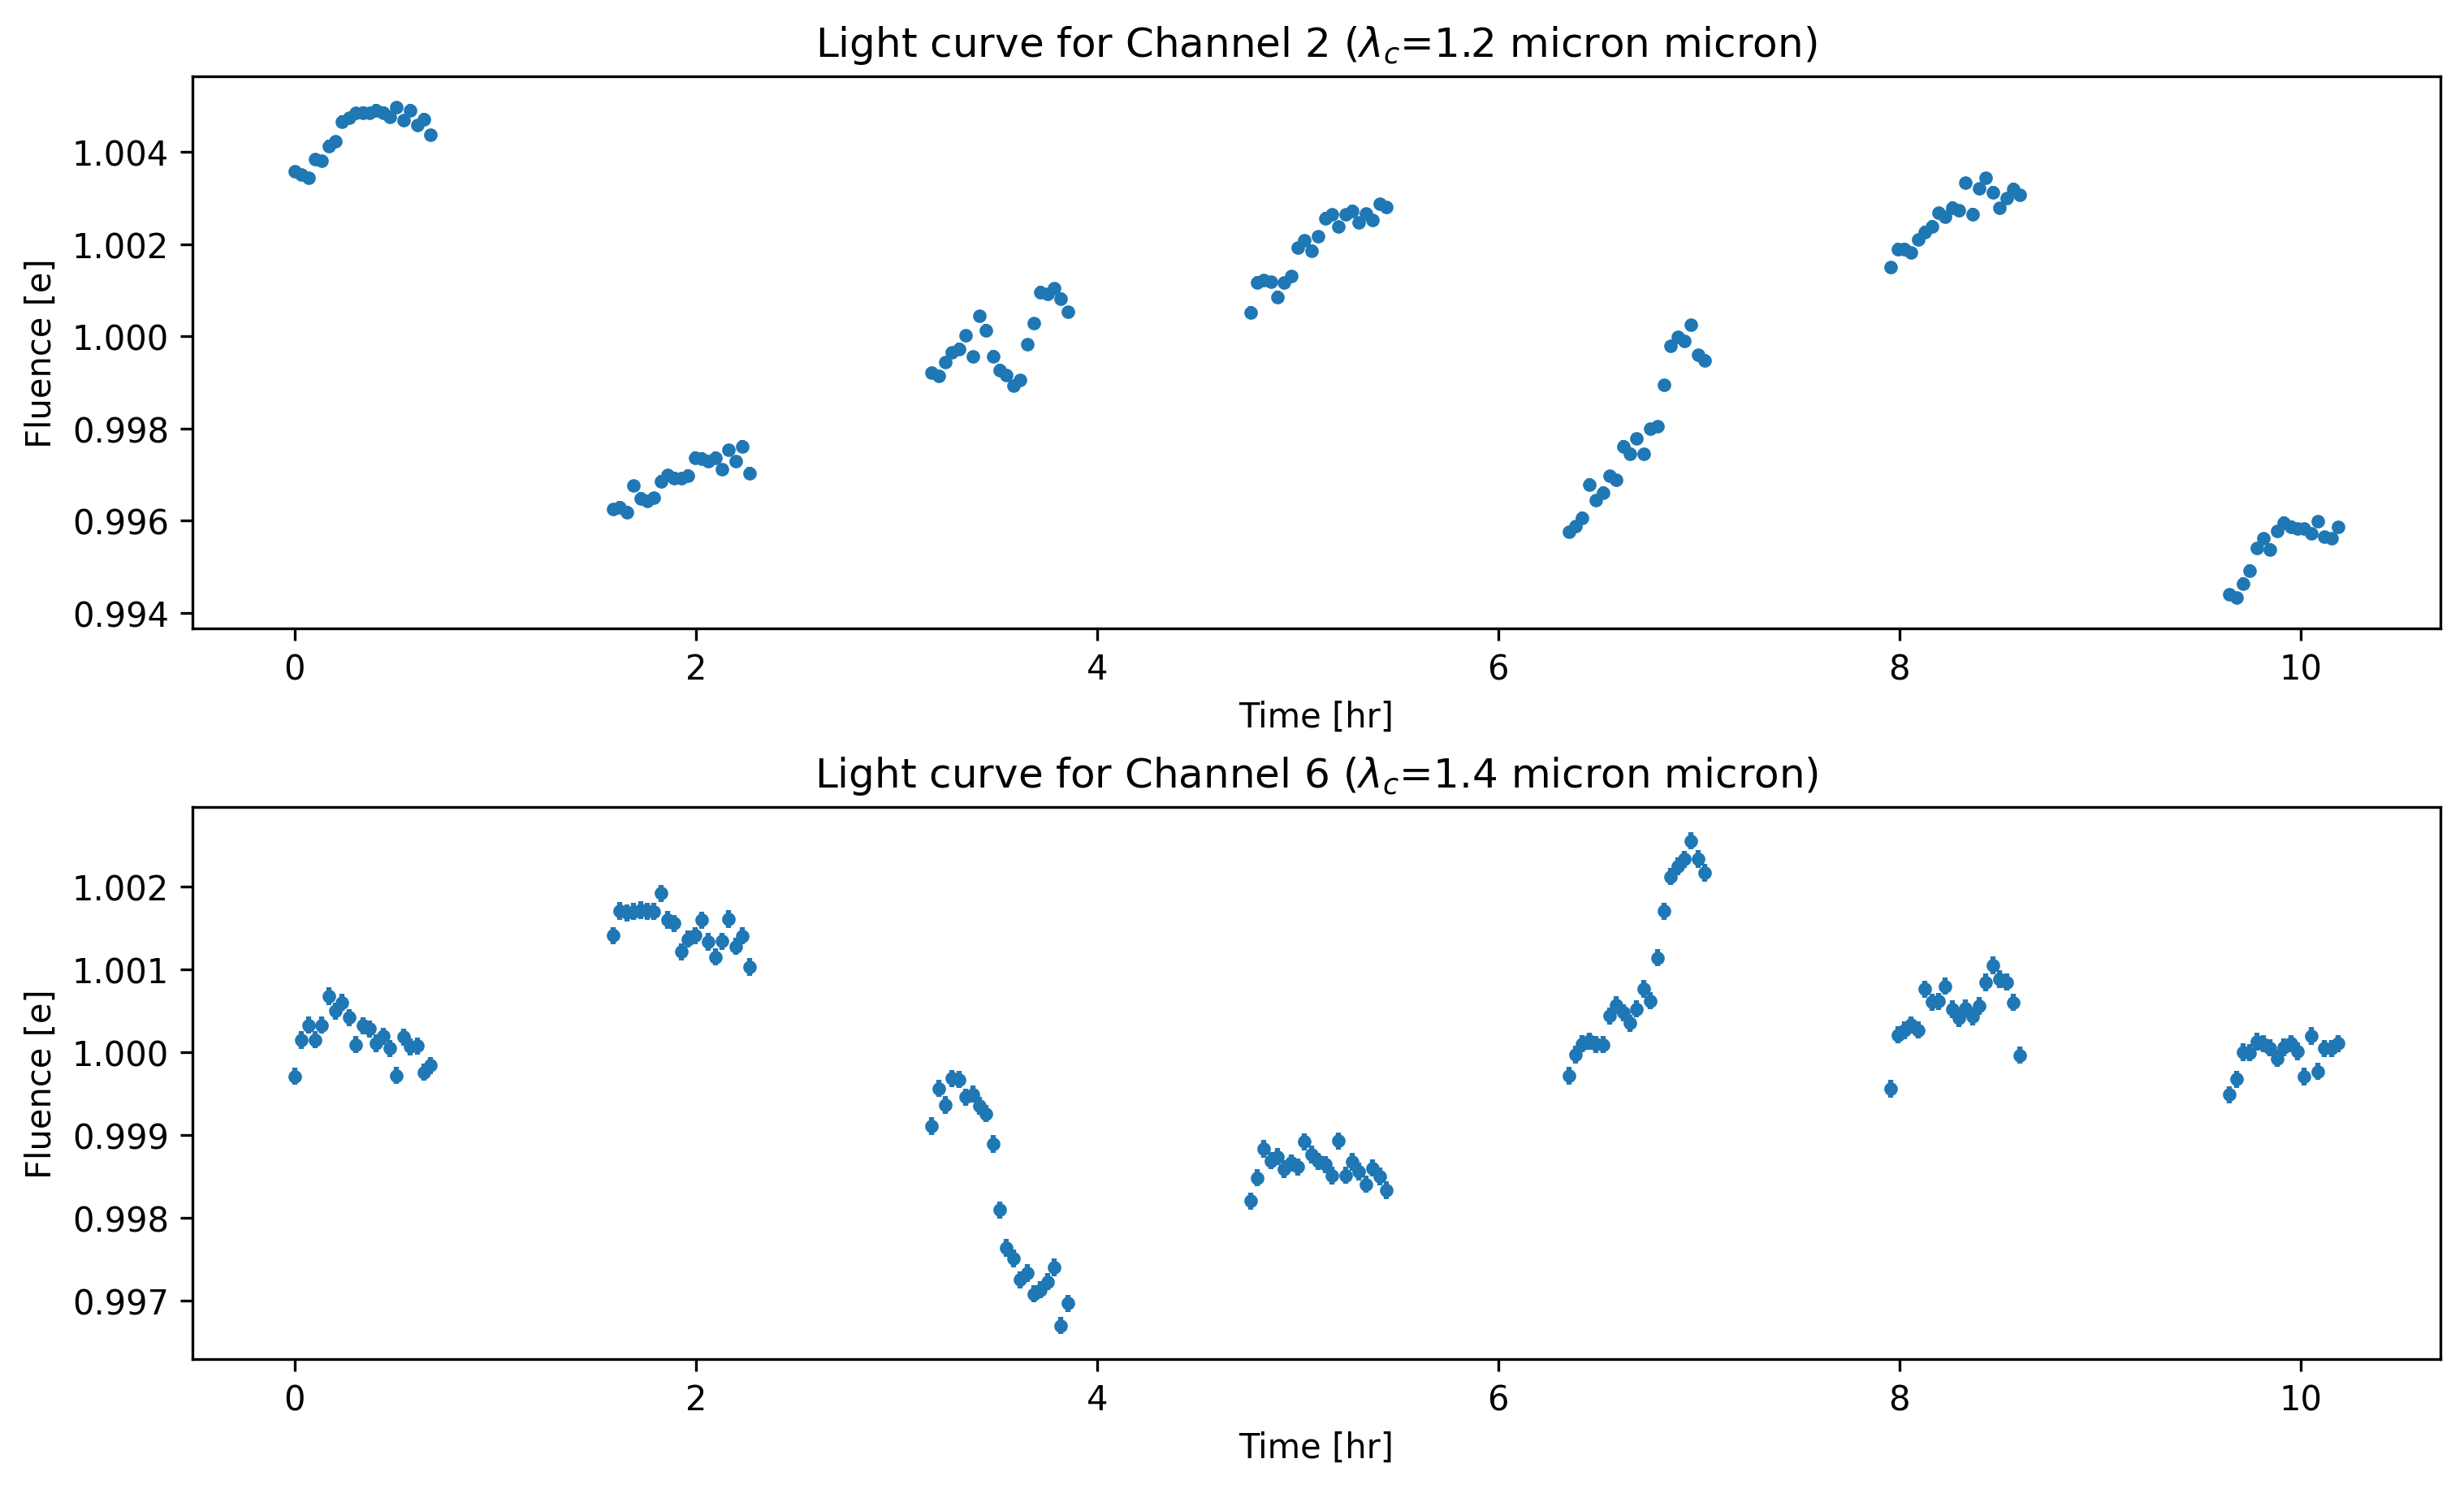

S22 Forward



🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/140 [00:00<?, ?it/s]

<Figure size 1920x1440 with 0 Axes>

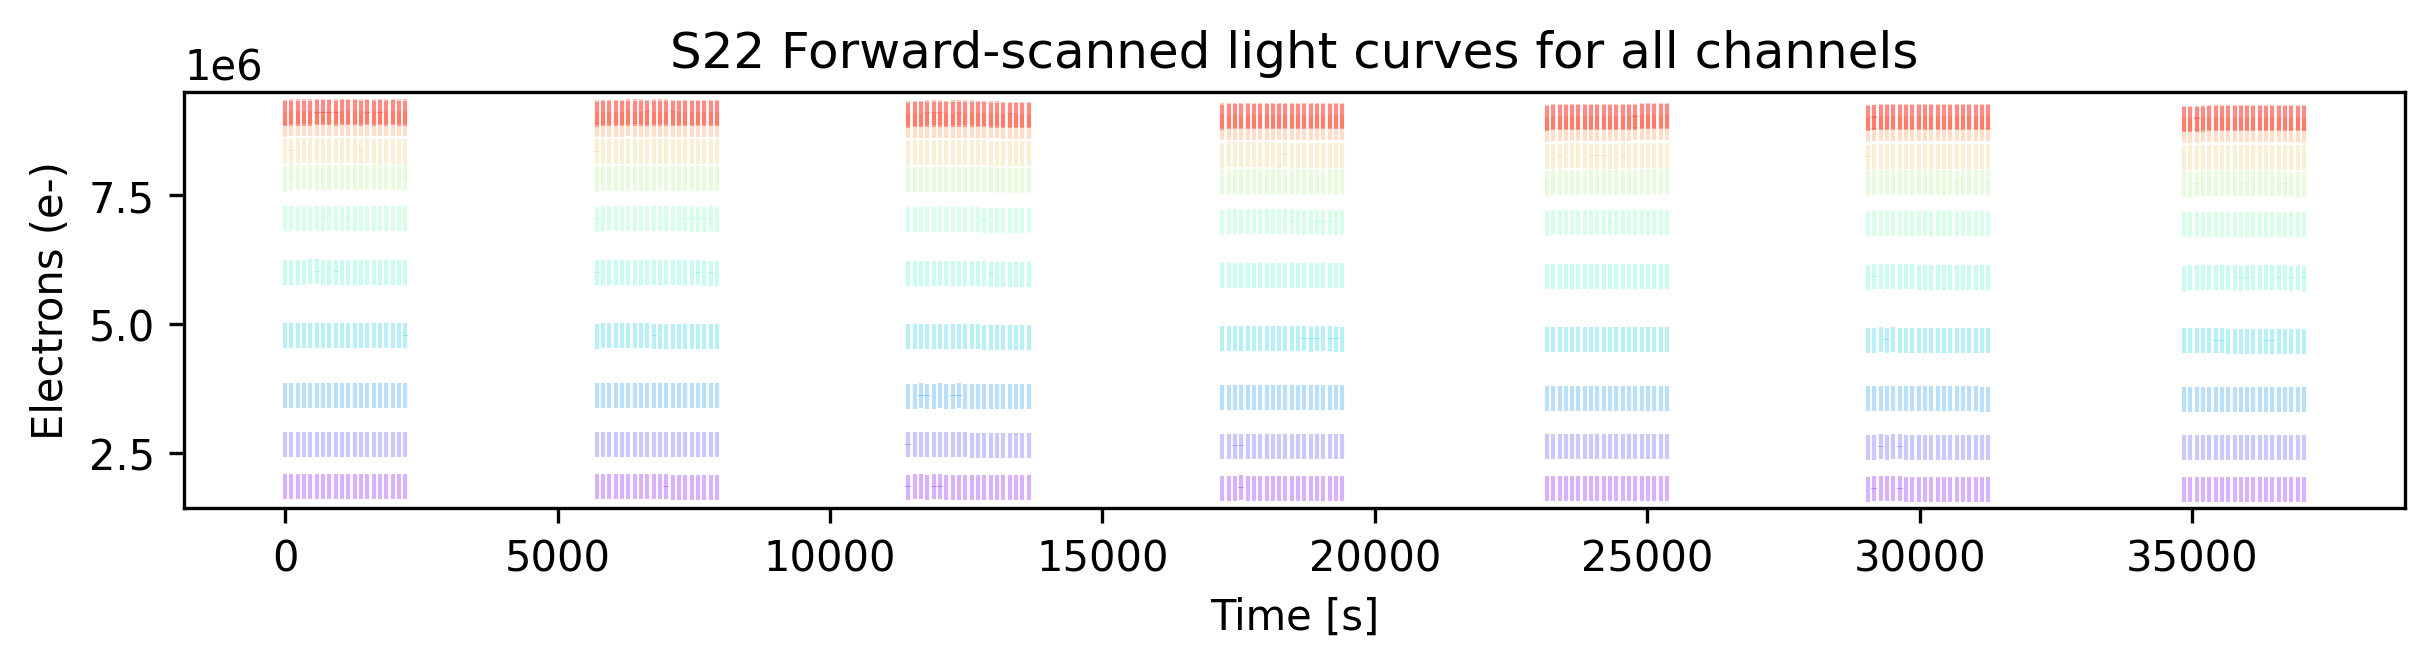

{'trap_pop_s': 199.99999999999991, 'trap_pop_f': 99.99999999999784, 'dTrap_f': 1.3368861573326285e-08, 'dTrap_s': 2.514456975966084e-08, 't_mid': 31220.5254896192, 'rp_rstar': 0.11581854807908802, 'a_rstar': 14.000314444580102, 'u1': 0.09964331043867548, 'u2': 0.4285659646923774, 'c1': -1.5297342730133638, 'c2': -188.3195716424342, 'c3': 169974666.8732097, 'crate': 1850905.0208928767, 'slope': -3.0}
{'trap_pop_s': 199.9999999999928, 'trap_pop_f': 100.0, 'dTrap_f': 0.0, 'dTrap_s': 3.3306690738754696e-14, 't_mid': 34348.823426684976, 'rp_rstar': 0.08833558752368871, 'a_rstar': 19.668467904787807, 'u1': 0.28254121545160843, 'u2': 0.35167213923552865, 'c1': -1.1615038342894013, 'c2': -1335.3660481698705, 'c3': 87595580.21192603, 'crate': 2665782.580193475, 'slope': -3.0}
{'trap_pop_s': 199.9999984698419, 'trap_pop_f': 99.999999753847, 'dTrap_f': 4.576964363067759e-07, 'dTrap_s': 8.97431184920805e-08, 't_mid': 34196.813261425996, 'rp_rstar': 0.08483449788948155, 'a_rstar': 20.3041918637133,

<Figure size 1920x1440 with 0 Axes>

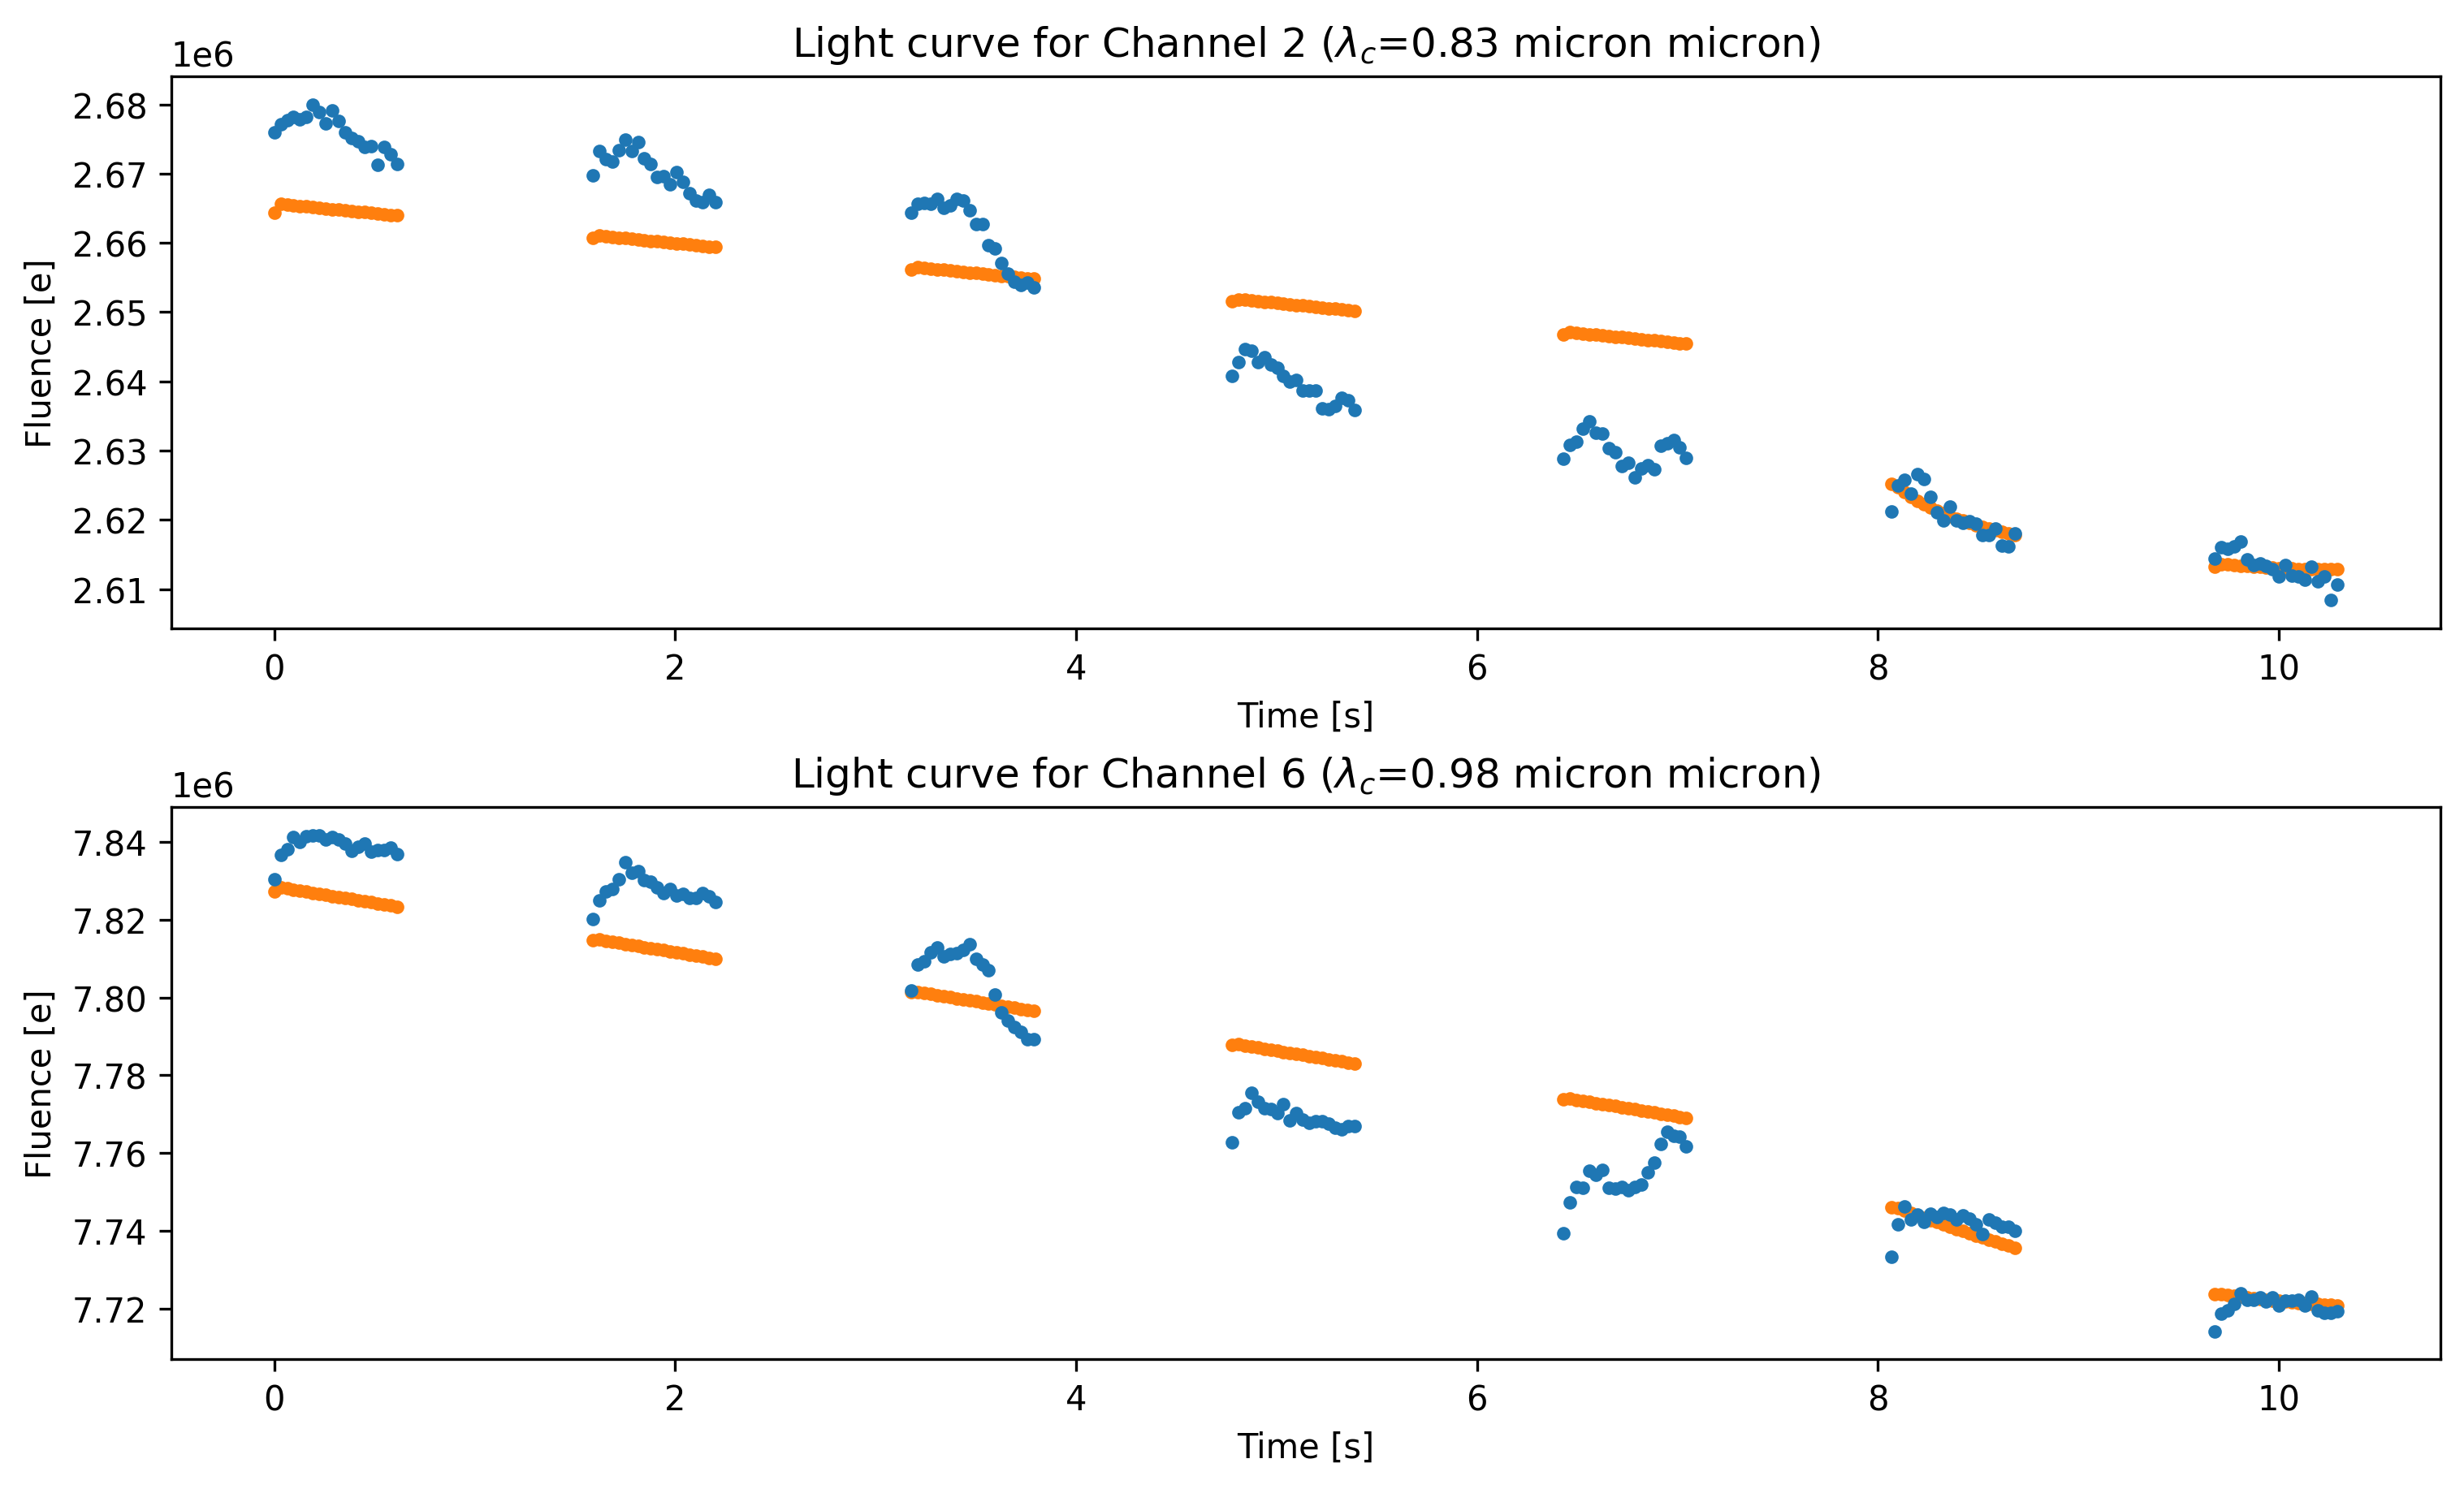

<Figure size 1920x1440 with 0 Axes>

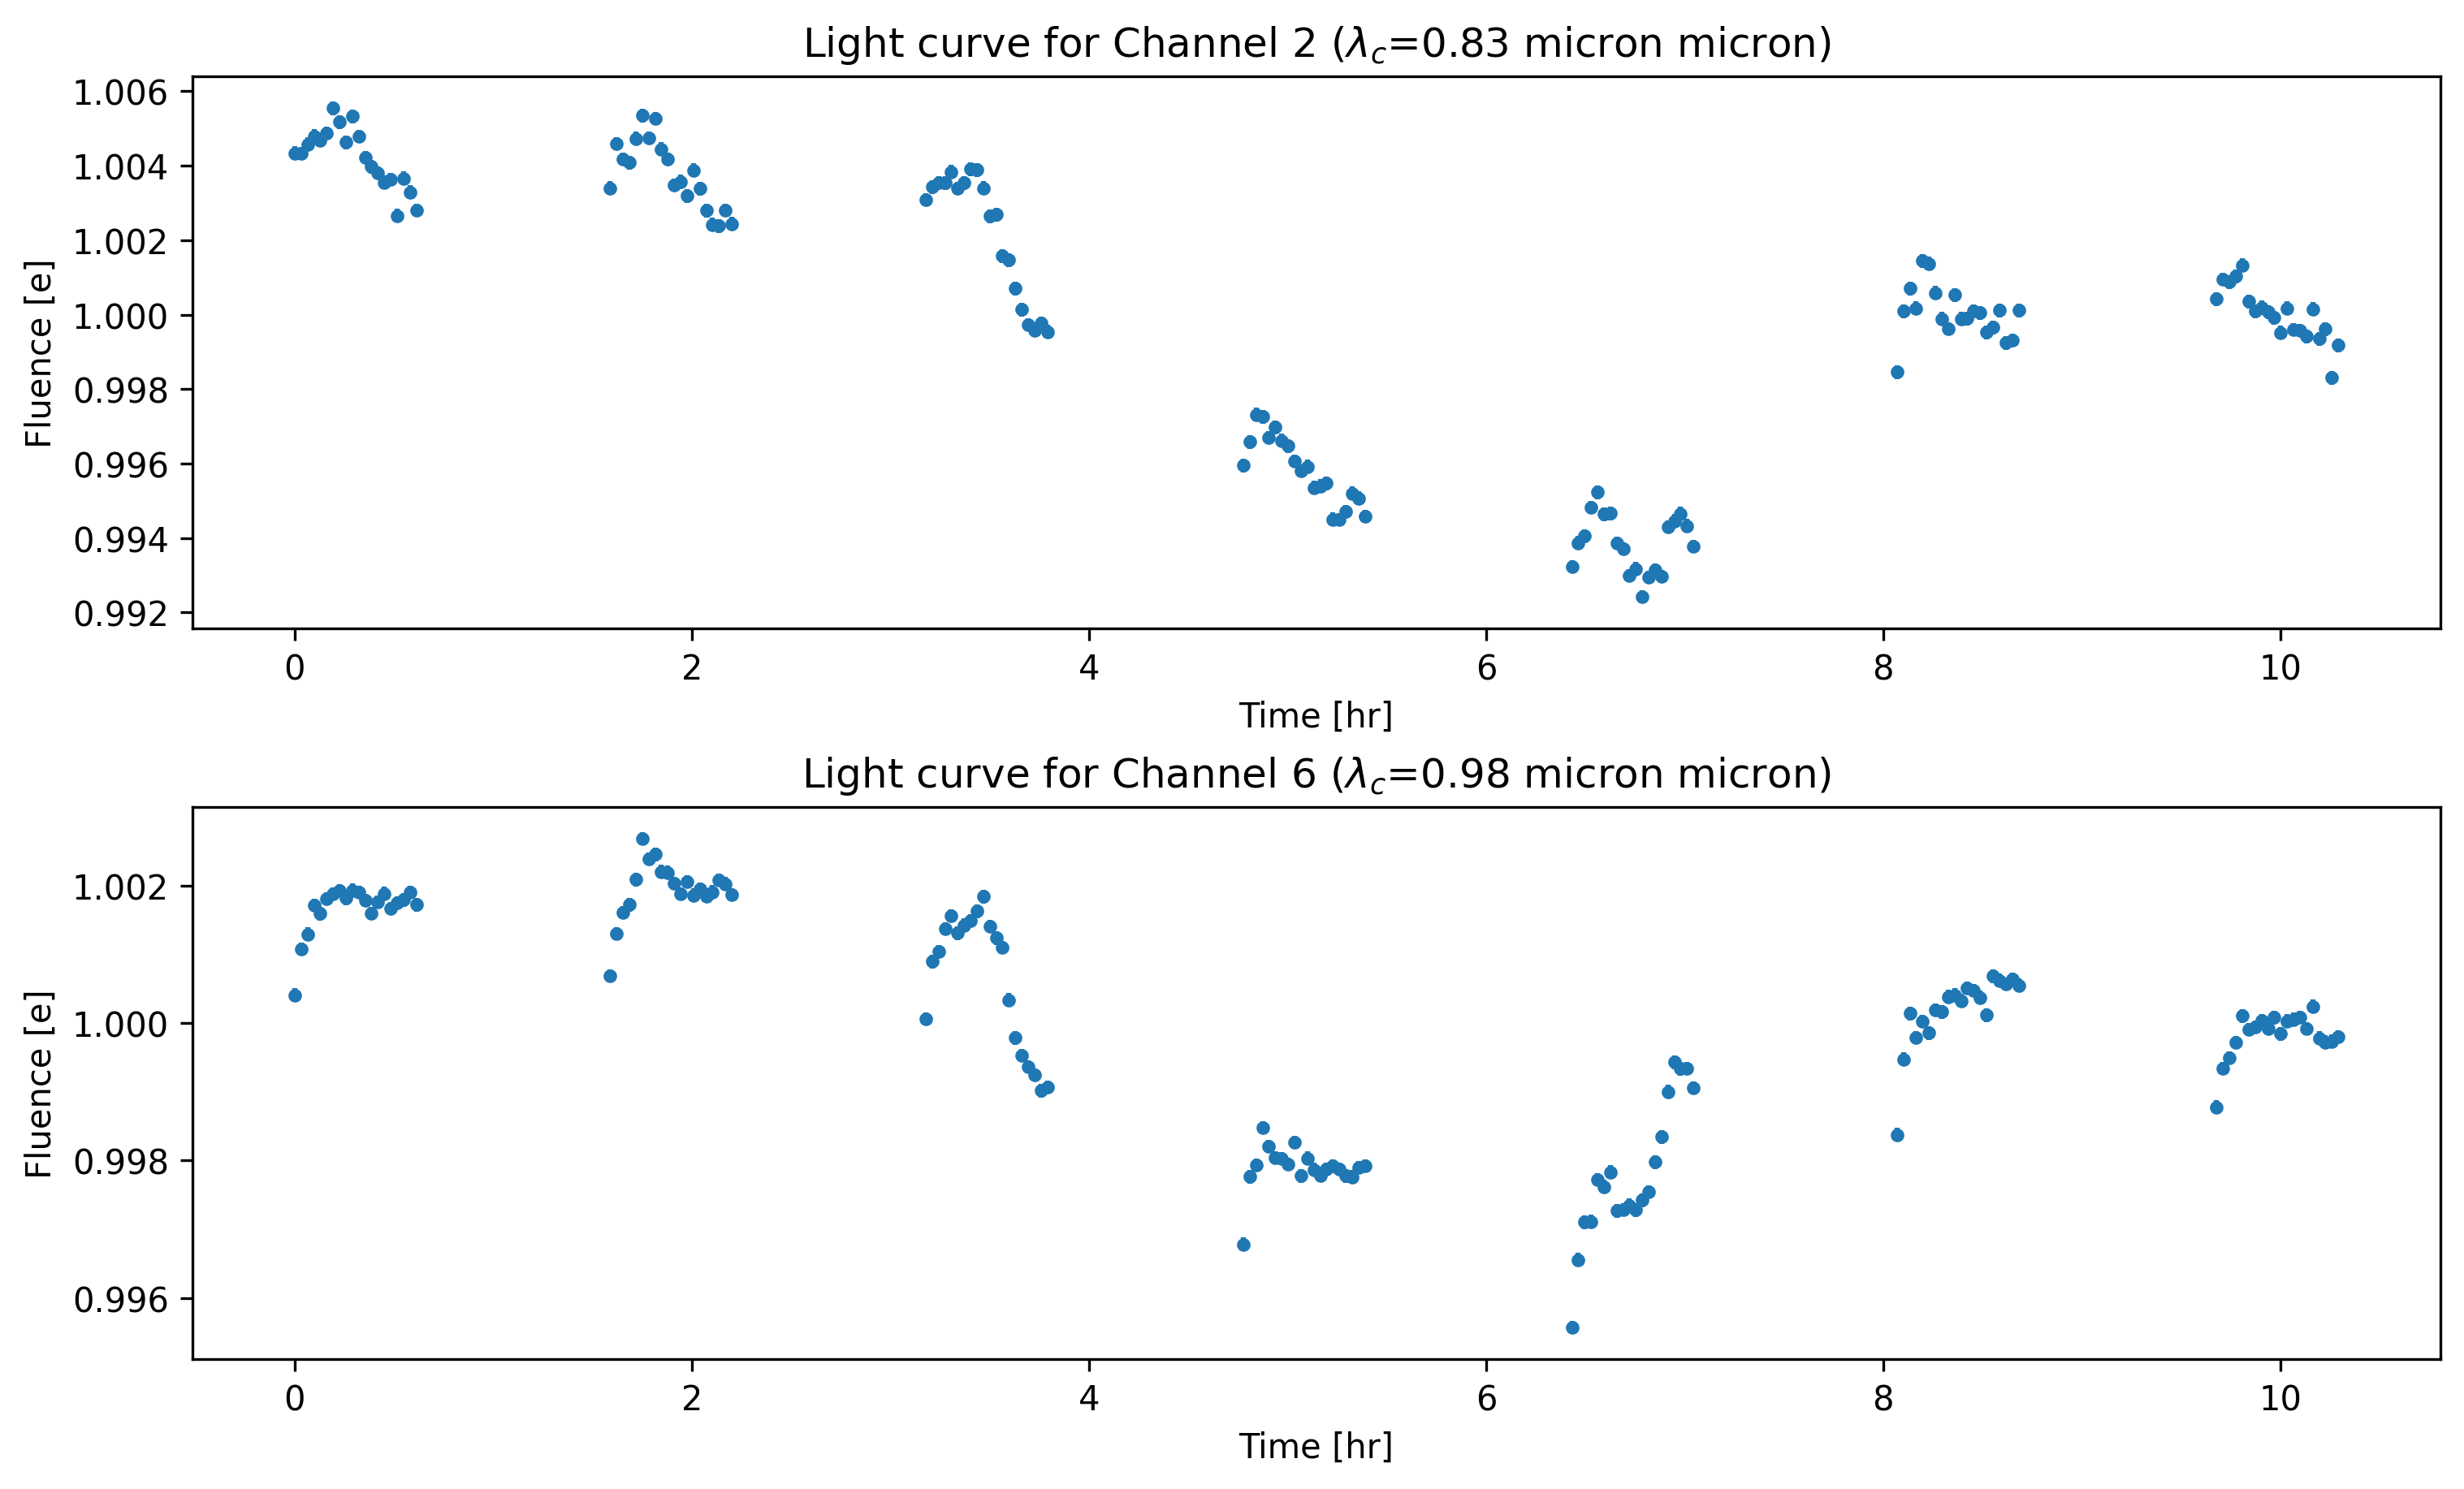

S22 Backward



🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/140 [00:00<?, ?it/s]

<Figure size 1920x1440 with 0 Axes>

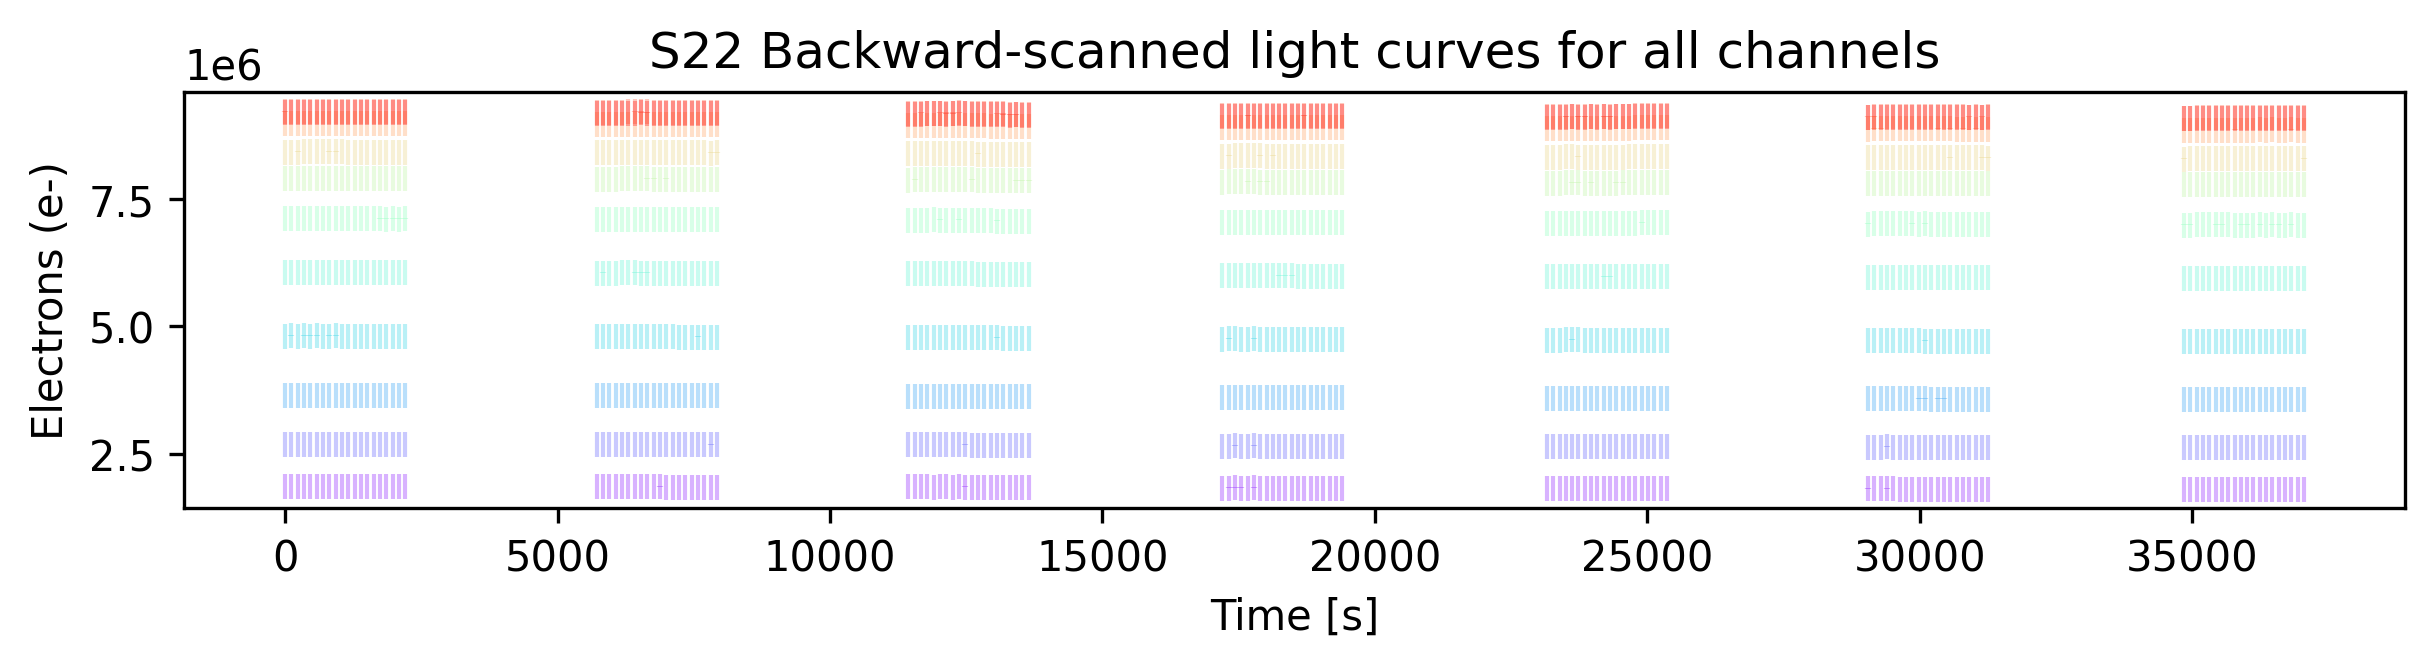

{'trap_pop_s': 199.99999997742597, 'trap_pop_f': 99.99999991281892, 'dTrap_f': 175.25343489872384, 'dTrap_s': 97.76851055177893, 't_mid': 31225.904022076345, 'rp_rstar': 0.11822841834996822, 'a_rstar': 14.002200453919572, 'u1': 0.01000039953204304, 'u2': 0.49956364346056825, 'c1': 0.0756692105474557, 'c2': -906.63402752868, 'c3': 148968142.1250337, 'crate': 1855958.625749867, 'slope': -2.9999999999998446}
{'trap_pop_s': 199.99999999999994, 'trap_pop_f': 99.99999999994465, 'dTrap_f': 2.2702950630559826e-10, 'dTrap_s': 5.74583447487953e-07, 't_mid': 34396.8641504368, 'rp_rstar': 0.08968928185485979, 'a_rstar': 19.413617836202807, 'u1': 0.23368073617592433, 'u2': 0.49999999994496647, 'c1': 0.2527013756732118, 'c2': -152.05769977986768, 'c3': 83986282.24983405, 'crate': 2681178.542168033, 'slope': -3.0}
{'trap_pop_s': 199.99999920716925, 'trap_pop_f': 99.99999984244153, 'dTrap_f': 0.0004254664261682528, 'dTrap_s': 0.00013084039990340912, 't_mid': 34646.26766302977, 'rp_rstar': 0.0855480615

<Figure size 1920x1440 with 0 Axes>

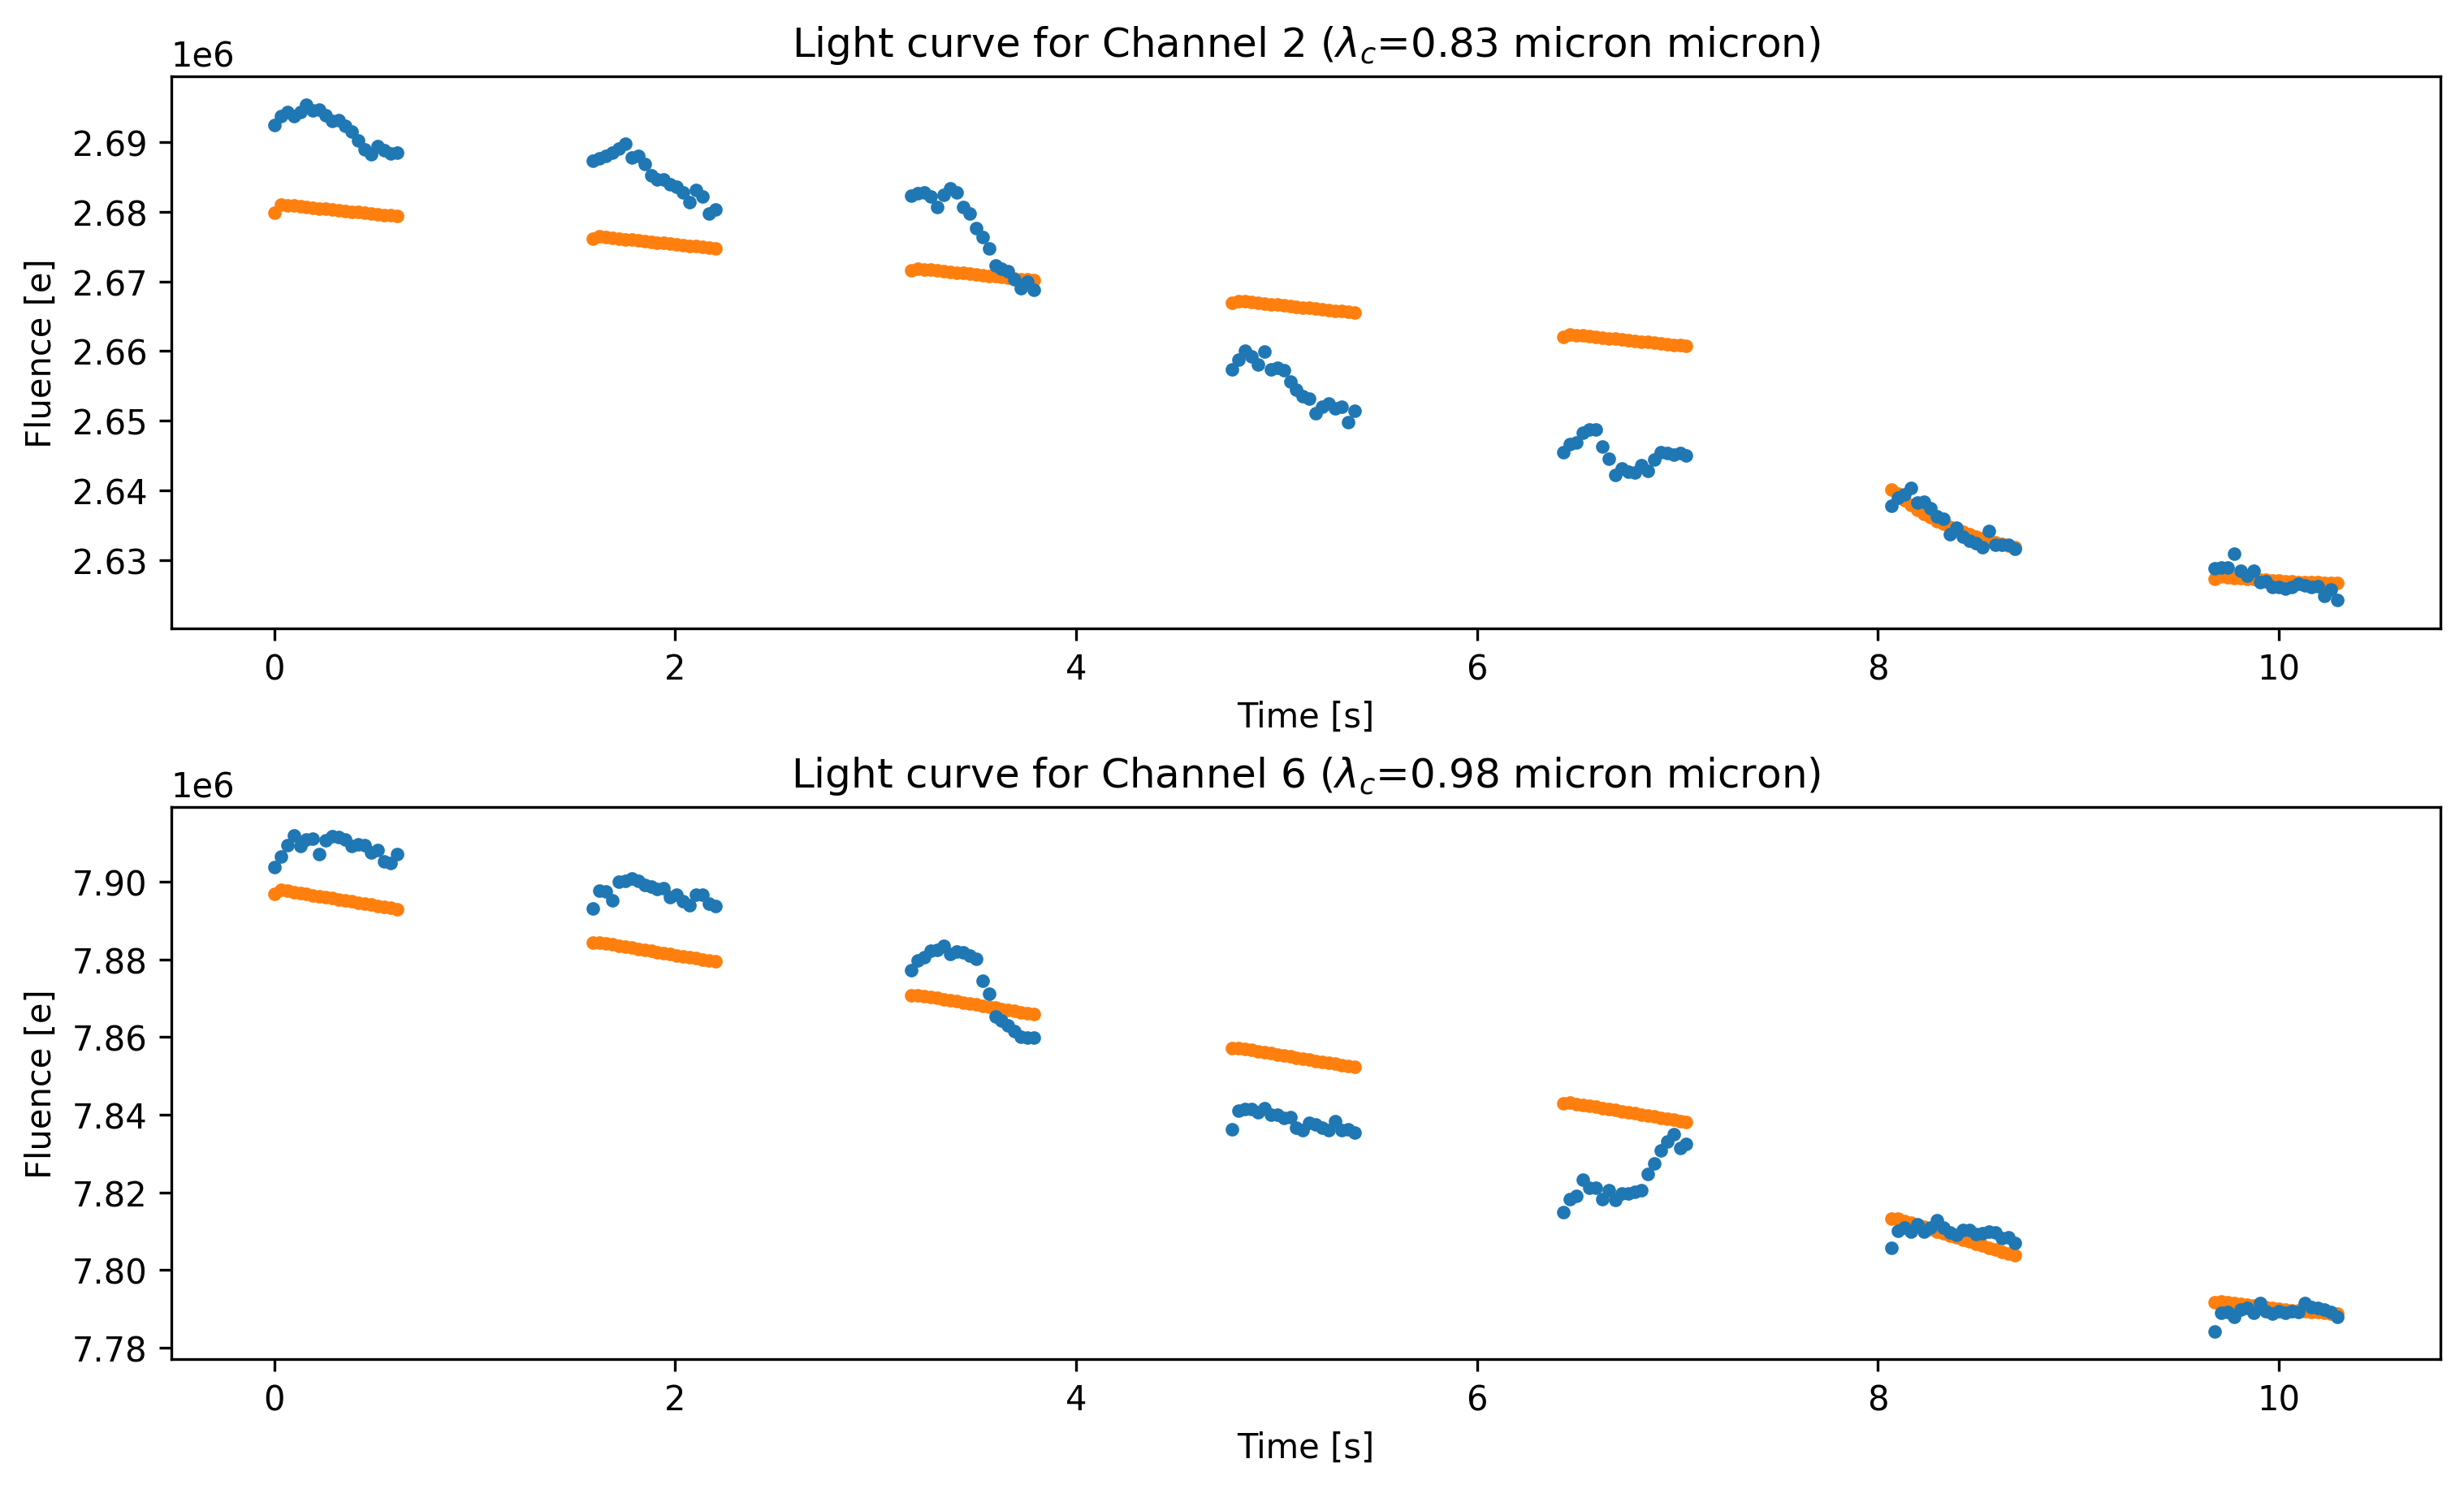

<Figure size 1920x1440 with 0 Axes>

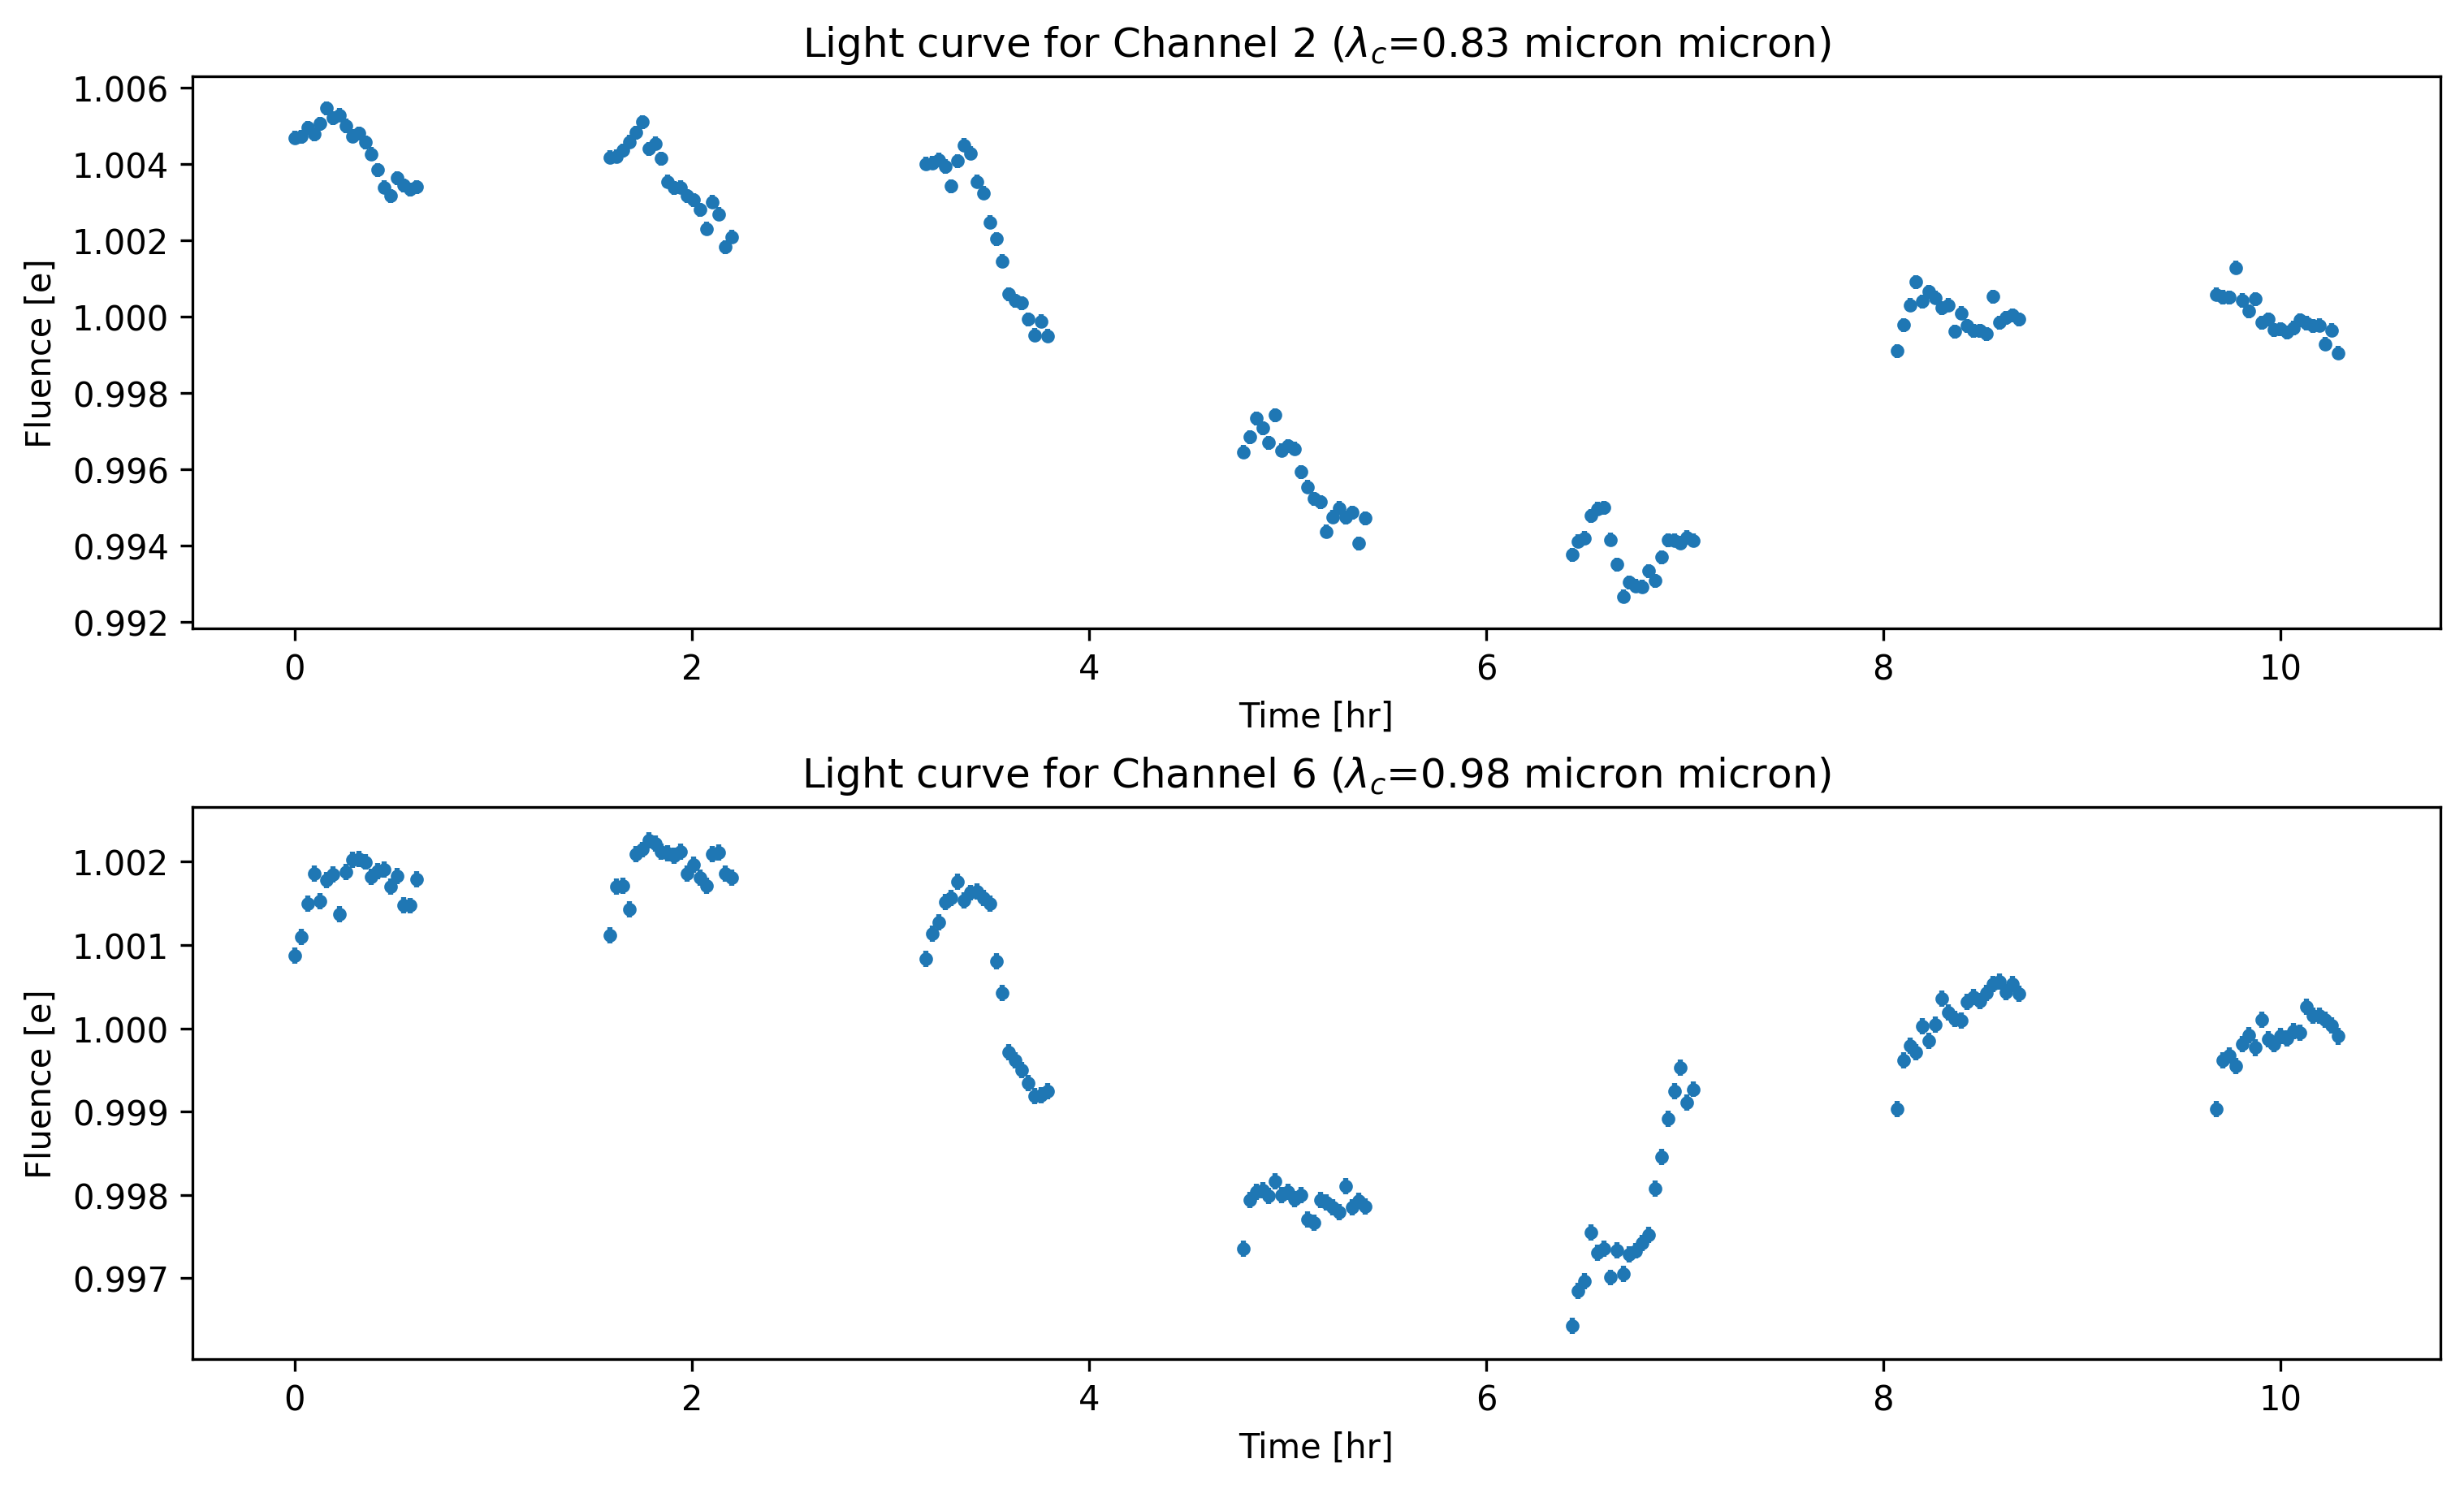

<Figure size 1920x1440 with 0 Axes>

In [132]:
for visit in visits:
    
    for direction in ['Forward','Backward']:
        print(visit, direction)
        print('')

        # Load data tables
        trimmed_rainbow = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy')
        trimmed_r = trimmed_rainbow.bin(R=30,minimum_points_per_bin=1)
        img_date = trimmed_r.time.value

        if direction == 'Forward':
            scanDirect = np.zeros_like(img_date)
        if direction == 'Backward':
            scanDirect = np.ones_like(img_date)
        
        spec = visits[f'{visit}'][f'{direction}']
        T0 = visits[f'{visit}']['T0 (BJD_TDB)']
        expTime = visits[f'{visit}']['exp (s)']

        spec['orbit'] = {}
        orbit = np.zeros_like(img_date)
        time_in_seconds = img_date * 24*60*60
        for j in range(len(orbit)):
            if j >= 1:
                if (time_in_seconds[j] - time_in_seconds[j - 1]) > 900:
                    orbit[j] = orbit[j - 1] + 1
                    # print(j)
                else:
                    orbit[j] = orbit[j - 1]
        spec['orbit'] = orbit

        LCarray = trimmed_r.flux*1.59 # Cube of data, flux array for each wavelength bin
        ERRarray =  trimmed_r.uncertainty*np.sqrt(1.59) # ndarray, 3rd dimension has 12 elements for the 12 wavelength bins
        wavelength = trimmed_r.wavelength # Central value of the wavelength bin, in microns
        time = ( time_in_seconds - time_in_seconds.min() )
        
        orbit_transit = np.array([])  # transit occurs in the third and fourth orbits
        
        # plot light curve at various wavelengths
        cmap = plt.get_cmap('rainbow', len(wavelength) )
        fig1 = plt.figure(figsize=(8,3.5))
        ax1 = fig1.add_subplot(211)
        for k in range(len(wavelength)):
            ax1.errorbar(time, LCarray[k, :], yerr=ERRarray[k, :], fmt='|',alpha=0.3,color=cmap(k))
        ax1.set_title(f'{visit} {direction}-scanned light curves for all channels')
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('Electrons (e-)')
        plt.savefig(f'../figs/{visit}_{direction}_muticolorLC.png')
        plt.show()
        plt.clf()

        """ Calculate the best fit models """
        p = Parameters()
        p.add('trap_pop_s', value=0, min=0, max=200, vary=True)
        p.add('trap_pop_f', value=0, min=0, max=100, vary=True)
        p.add('dTrap_f', value=0, min=0, max=200, vary=True)
        p.add('dTrap_s', value=50, min=0, max=100, vary=True)
        p.add('t_mid', value=np.nanmedian(time), min=time.min(),
              max=time.max(),vary=True)
        p.add('rp_rstar', value=0.05, min=0, max=0.9, vary=True)
        p.add('a_rstar', value=18, min=14, max=22, vary=True)
        p.add('u1', value=0.1,min=0.01,max=1,vary=True)
        p.add('u2', value=0.1,min=-0.5,max=0.5,vary=True)
        p.add('c1', value=0, vary=True)
        p.add('c2', value=-3, min=-np.inf, max=0, vary=True)
        p.add('c3', value=1e6, min=0, vary=True)
        LCarray_noRamp, ERRarray_noRamp, Modelarray, cratearray, slopearray = removeRamp(
            p, 
            time, 
            LCarray, 
            ERRarray, 
            orbit, 
            orbit_transit,
            expTime,
            scanDirect)
        
        fig2 = plt.figure(figsize=(10, 6))
        ax1 = fig2.add_subplot(211)
        ax1.errorbar(
            time / 3600,
            LCarray[1, :],
            yerr=ERRarray[1, :],
            fmt='.',
            ls='')
        for o in [0, 1, 2, 3, 4, 5, 6]:
            ax1.plot(
                time[orbit == o] / 3600,
                Modelarray[1, orbit == o],
                '.-',
                color='C1')
        ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('Fluence [e]')
        
        ax2 = fig2.add_subplot(212)
        ax2.errorbar(
            time / 3600,
            LCarray[6, :],
            yerr=ERRarray[6, :],
            fmt='.',
            ls='')
        for o in [0, 1, 2, 3, 4, 5, 6]:
            ax2.plot(
                time[orbit == o] / 3600,
                Modelarray[6, orbit == o],
                '.-',
                color='C1')
        ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Fluence [e]')
        plt.savefig(f'../figs/{visit}_{direction}_ramp_model.png')
        plt.show()
        plt.clf()

        fig3 = plt.figure(figsize=(10, 6))
        ax1 = fig3.add_subplot(211)
        
        ax1.errorbar(
            time / 3600,
            LCarray_noRamp[1, :],
            yerr=ERRarray_noRamp[1, :],
            fmt='.',
            ls='')
        ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
        ax1.set_xlabel('Time [hr]')
        ax1.set_ylabel('Fluence [e]')
        
        ax2 = fig3.add_subplot(212)
        ax2.errorbar(
            time / 3600,
            LCarray_noRamp[6, :],
            yerr=ERRarray_noRamp[6, :],
            fmt='.',
            ls='')
        
        ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
        ax2.set_xlabel('Time [hr]')
        ax2.set_ylabel('Fluence [e]')
        plt.savefig(f'../figs/{visit}_{direction}_corrected.png')
        plt.show()
        plt.clf()